## A Deeper Analysis of Adversarial Examples in Intrusion Detection

## Libraries import

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import copy
import time as time

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from sklearn.metrics import classification_report
from sklearn.decomposition import PCA
from sklearn.feature_selection import chi2

!pip install adversarial-robustness-toolbox >/dev/null
from art.attacks.evasion import FastGradientMethod, BasicIterativeMethod, DeepFool, CarliniL2Method, CarliniLInfMethod
from art.classifiers import PyTorchClassifier

%matplotlib inline

pd.options.display.max_columns = 200
pd.options.display.max_rows = 200

## NSL-KDD Pre-Processing

### Dowloading and importing the dataset

In [ ]:
#Downloading and extracting the dataset if it doesn't exist
!if [ ! -d "./NSL-KDD" ]; then wget http://205.174.165.80/CICDataset/NSL-KDD/Dataset/NSL-KDD.zip; mkdir NSL-KDD; unzip NSL-KDD.zip -d NSL-KDD; fi
    
#Importing the training and testing datasets from .CSV to Pandas DataFrames
features = ['1 Duration', '2 Protocol-type : ', '3 Service : ', '4 Flag : ', '5 Src-bytes', '6 Dst-bytes', '7 Land', '8 Wrong-fragment', '9 Urgent', '10 Hot', '11 Num-failed-logins', '12 Logged-in', '13 Num-compromised', '14 Root-shell', '15 Su-attempted', '16 Num-root', '17 Num-file-creations', '18 Num-shells', '19 Num-access-files', '20 Num-outbound-cmds', '21 Is-host-login', '22 Is-guest-login', '23 Count', '24 Srv-count', '25 Serror-rate', '26 Srv-serror-rate', '27 Rerror-rate', '28 Srv-rerror-rate', '29 Same-srv-rate', '30 Diff-srv-rate', '31 Srv-diff-host-rate', '32 Dst-host-count', '33 Dst-host-srv-count', '34 Dst-host-same-srv-rate', '35 Dst-host-diff-srv-rate', '36 Dst-host-same-src-port-rate', '37 Dst-host-srv-diff-host-rate', '38 Dst-host-serror-rate', '39 Dst-host-srv-serror-rate', '40 Dst-host-rerror-rate', '41 Dst-host-srv-rerror-rate', '42 Attack_type', '43 Difficulty']
df_training = pd.read_csv('./NSL-KDD/KDDTrain+.txt', names=features)
df_testing = pd.read_csv('./NSL-KDD/KDDTest+.txt', names=features)
# Stack the training and test sets
data = pd.concat([df_training, df_testing], axis=0)

--2020-08-24 08:20:25--  http://205.174.165.80/CICDataset/NSL-KDD/Dataset/NSL-KDD.zip
Connecting to 205.174.165.80:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6598776 (6.3M) [application/zip]
Saving to: ‘NSL-KDD.zip’

NSL-KDD.zip         100%[===================>]   6.29M  1.69MB/s    in 3.7s    

2020-08-24 08:20:31 (1.69 MB/s) - ‘NSL-KDD.zip’ saved [6598776/6598776]

Archive:  NSL-KDD.zip
  inflating: NSL-KDD/index.html      
  inflating: NSL-KDD/KDDTest1.jpg    
  inflating: NSL-KDD/KDDTest-21.arff  
  inflating: NSL-KDD/KDDTest-21.txt  
  inflating: NSL-KDD/KDDTest+.arff   
  inflating: NSL-KDD/KDDTest+.txt    
  inflating: NSL-KDD/KDDTrain1.jpg   
  inflating: NSL-KDD/KDDTrain+.arff  
  inflating: NSL-KDD/KDDTrain+.txt   
  inflating: NSL-KDD/KDDTrain+_20Percent.arff  
  inflating: NSL-KDD/KDDTrain+_20Percent.txt  


### Removing unused features

In [ ]:
# Drop the last column (which might be the difficulty, so it's useless)
data.drop('43 Difficulty', inplace=True, axis=1)
# Drop the 19th column wich is full of 0, so has std=0. which causes issues for the normalization
data.drop('20 Num-outbound-cmds', inplace=True, axis=1)

### Transforming the problem into binary clasification

In [ ]:
# Transform the nominal attribute "Attack type" into binary (0 : normal / 1 : attack)
labels = (data['42 Attack_type'] != 'normal').astype('int64')
data['42 Labels'] = labels
data.drop('42 Attack_type', inplace=True, axis=1)

### One Hot Encoding the categorical features

In [ ]:
# One Hot Encode the 3 first nominal attributes and drop them
for i in ['4 Flag : ', '3 Service : ', '2 Protocol-type : ']:
    # Create the One Hot Encode DataFrame
    dum = pd.get_dummies(data[i])
    # Insert into the dataset DataFrame by Series
    for column_name in list(dum.columns):
        data.insert(1, str(i)+column_name, dum[column_name])
        data[str(i)+column_name] = data[str(i)+column_name].astype('int64')
    # Drop the old attribute's column
    data.drop(i, inplace=True, axis=1)

### Spliting the training and test set 

In [ ]:
# Split training and test sets
df_training = data[:df_training.shape[0]]    
df_testing = data[df_training.shape[0]:]

### Normalizing the data using Min-Max

In [ ]:
# Min-Max normalization on the non binary features
for i in ['1 Duration', '5 Src-bytes', '6 Dst-bytes', '8 Wrong-fragment', '9 Urgent', '10 Hot', '11 Num-failed-logins', '13 Num-compromised', '15 Su-attempted', '16 Num-root', '17 Num-file-creations', '18 Num-shells', '19 Num-access-files', '23 Count', '24 Srv-count', '25 Serror-rate', '26 Srv-serror-rate', '27 Rerror-rate', '28 Srv-rerror-rate', '29 Same-srv-rate', '30 Diff-srv-rate', '31 Srv-diff-host-rate', '32 Dst-host-count', '33 Dst-host-srv-count', '34 Dst-host-same-srv-rate', '35 Dst-host-diff-srv-rate', '36 Dst-host-same-src-port-rate', '37 Dst-host-srv-diff-host-rate', '38 Dst-host-serror-rate', '39 Dst-host-srv-serror-rate', '40 Dst-host-rerror-rate', '41 Dst-host-srv-rerror-rate']:
    # The min and max are only computed from the training set
    min = df_training[i].min()
    max = df_training[i].max()
    df_training[i] = ((df_training[i] - min) / (max - min)) 
    df_testing[i] = ((df_testing[i] - min) / (max - min)) 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


### Convert the training and testing set into NumPy array

In [ ]:
# Get NumPy arrays from DataFrames
nd_training = df_training.values
nd_testing = df_testing.values

### Extracting the labels and making copies

In [ ]:
# Separating arguments (x) from lables (y)
x_train = nd_training[:, :-1]
y_train = nd_training[:, -1]
x_test = nd_testing[:, :-1]
y_test = nd_testing[:, -1]

# Make a copy of the data set as NumPy arrays
x_train_np = x_train.copy()
y_train_np = y_train.copy()
x_test_np = x_test.copy()
y_test_np = y_test.copy()

## Neural Network Model Training

### Convert the training and testing set into PyTorch tensors

In [ ]:
# Convert from numpy array to torch tensors
x_train = torch.from_numpy(x_train).float()
y_train = torch.from_numpy(y_train).long()
x_test = torch.from_numpy(x_test).float()
y_test = torch.from_numpy(y_test).long()

### Define a neural network with 2 ReLU hidden layers and a Softmax output

In [ ]:
class Network(nn.Module):
    ''' A basic neural network model '''
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()         #python2 : super(MLP, self).__init__()
        #defining the network's operations
        self.fc1 = nn.Linear(input_size, hidden_size[0])
        self.fc2 = nn.Linear(hidden_size[0], hidden_size[1])
        self.fc3 = nn.Linear(hidden_size[1], output_size)

    def forward(self, x, softmax=False): 
        a = self.fc3(F.relu(self.fc2(F.relu(self.fc1(x.float())))))
        if softmax:
            y_pred = F.softmax(a, dim=1)
        else:
            y_pred = a

        return y_pred

### Define a function to compute the accuracy of the prediction

In [ ]:
def evaluate_predictions(predictions, real):
    ''' Evaluates the accuracy of the predictions'''
    n_correct = torch.eq(predictions, real).sum().item()
    accuracy = n_correct / len(predictions) * 100
    return accuracy

### Define a function that prints the models perfomance metrics

In [ ]:
def stat_model(model, x_train, y_train, x_test, y_test):
    ''' Prints statistics about the model performances on the dataset'''
    _, predictions_train = model(x_train, softmax=True).max(dim=1)
    #_, predictions_train = model(x_train).max(dim=1)
    accuracy_train = evaluate_predictions(predictions=predictions_train.long(), real=y_train)

    _, predictions_test = model(x_test, softmax=True).max(dim=1)
    #_, predictions_test = model(x_test).max(dim=1)
    accuracy_test = evaluate_predictions(predictions=predictions_test.long(), real=y_test)
    
    print("Final Training Accuracy: {0:.4f}%\nFinal Testing Accuracy : {1:.4f}%"
          .format(accuracy_train, accuracy_test))
    # Move the tensors back to CPU
    label_test_final = y_test.cpu().numpy()
    predictions_test_final = predictions_test.cpu().numpy()
    report = classification_report(label_test_final, predictions_test_final)
    print("Classification Report :")
    print(report)

### Train the model

In [ ]:
# Set fixed seeds for reproducibility
np.random.seed(1234)
torch.manual_seed(1234)

# Initialising the model
input_size=x_train.shape[1]
hidden_size=[256,256]
output_size=2
model = Network(input_size, hidden_size, output_size)

# Setting device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Training on : {}".format(device))

# Transfering model and data to GPU
model = model.to(device)
x_train = x_train.to(device)
y_train = y_train.to(device)
x_test = x_test.to(device)
y_test = y_test.to(device)

# Setting the Loss function and Adam learning rate
criterion = nn.CrossEntropyLoss()
lr = 0.01
optimizer = optim.Adam(model.parameters(), lr=lr)

# Variables to store the best performences (weights and accuracy)
best_model_weights = copy.deepcopy(model.state_dict())
best_accuracy = 0.0

# DataFrame for the learning curve plot
trace = pd.DataFrame(columns=['epoch', 'train_acc', 'test_acc'])
# Iterrating on the dataset
since = time.time()
for epoch in range(1000+1):
    # Forward pass
    y_pred = model(x_train) 
    # torch.max(dim=1) returns the maximum value of each line AND its index
    _, predictions = y_pred.max(dim=1)
    # Compute accuracy
    accuracy_train = evaluate_predictions(predictions=predictions.long(), real=y_train)
    # Compute loss
    loss = criterion(y_pred, y_train)

    # Testing model on the test set
    if epoch%10 == 0:
        _, predictions_test = model(x_test, softmax=True).max(dim=1)
        accuracy_test = evaluate_predictions(predictions=predictions_test.long(), real=y_test)
        # Keep track of the accuracies for the learning curve
        trace = trace.append([{'epoch':epoch,
                                'train_acc':accuracy_train,
                                'test_acc':accuracy_test}])
        # Save the best model's accuracy and parameters
        if accuracy_test > best_accuracy:
            best_accuracy = accuracy_test
            best_model_weights = copy.deepcopy(model.state_dict())
        # Displap statistics
        if epoch%100 == 0:
            time_elapsed = time.time() - since
            print("epoch: {0:4d} | loss: {1:.4f} | Train accuracy: {2:.4f}% | Test accuracy: {3:.4f}% [{4:.4f}%] | Running for : {5:.0f}m {6:.0f}s"
                  .format(epoch,
                          loss,
                          accuracy_train,
                          accuracy_test,
                          best_accuracy,
                          time_elapsed // 60,
                          time_elapsed % 60))

    # Zero all gradients
    optimizer.zero_grad()
    # Backward pass
    loss.backward()
    # Update weights
    optimizer.step()

# Compute the training time
time_elapsed = time.time() - since
print('Training complete in {:.0f}m {:.0f}s'.format(
    time_elapsed // 60, time_elapsed % 60))

Training on : cuda
epoch:    0 | loss: 0.6966 | Train accuracy: 33.6532% | Test accuracy: 20.0630% [20.0630%] | Running for : 0m 0s
epoch:  100 | loss: 0.0153 | Train accuracy: 99.5213% | Test accuracy: 81.1879% [81.1879%] | Running for : 0m 3s
epoch:  200 | loss: 0.0067 | Train accuracy: 99.7571% | Test accuracy: 83.6364% [84.1909%] | Running for : 0m 6s
epoch:  300 | loss: 0.0052 | Train accuracy: 99.8063% | Test accuracy: 83.3836% [84.1909%] | Running for : 0m 9s
epoch:  400 | loss: 0.0044 | Train accuracy: 99.8357% | Test accuracy: 82.2436% [84.1909%] | Running for : 0m 12s
epoch:  500 | loss: 0.0043 | Train accuracy: 99.8627% | Test accuracy: 82.8513% [84.1909%] | Running for : 0m 15s
epoch:  600 | loss: 0.0036 | Train accuracy: 99.8722% | Test accuracy: 82.3634% [84.1909%] | Running for : 0m 18s
epoch:  700 | loss: 0.0038 | Train accuracy: 99.8460% | Test accuracy: 81.5960% [84.1909%] | Running for : 0m 21s
epoch:  800 | loss: 0.0031 | Train accuracy: 99.8801% | Test accuracy: 82

### Display the learning curve and the model performances

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


Final Training Accuracy: 99.5832%
Final Testing Accuracy : 84.1909%
Classification Report :
              precision    recall  f1-score   support

           0       0.75      0.96      0.84      9711
           1       0.96      0.75      0.84     12833

    accuracy                           0.84     22544
   macro avg       0.85      0.86      0.84     22544
weighted avg       0.87      0.84      0.84     22544



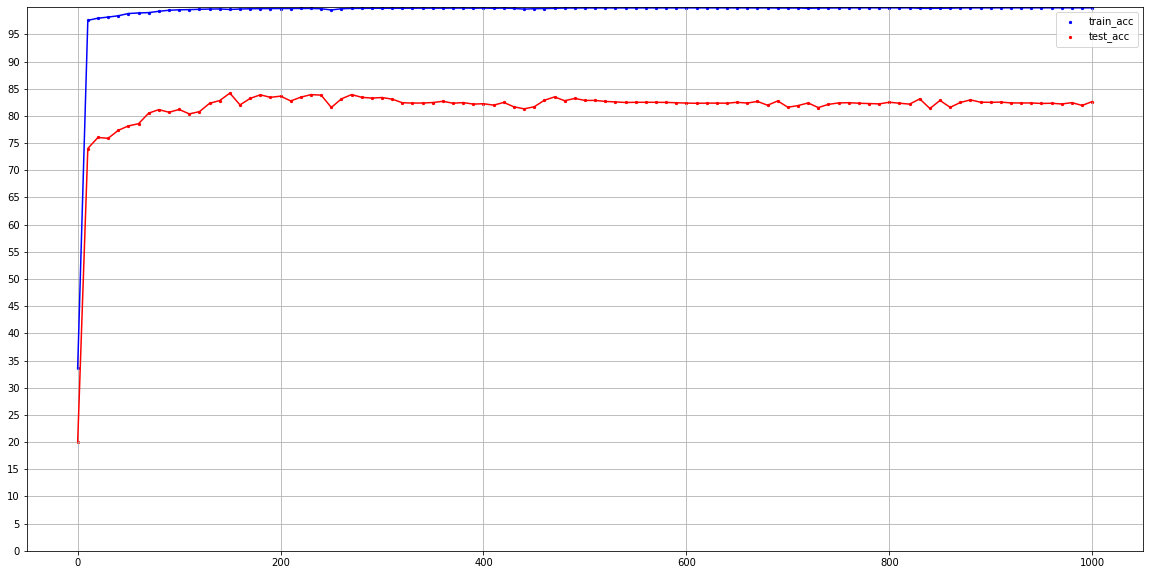

In [ ]:
# Draw the learning curve
plt.figure(figsize=(20, 10))
plt.scatter(data=trace, x='epoch', y='train_acc', c="b", s=5)
plt.scatter(data=trace, x='epoch', y='test_acc', c="r", s=5)
plt.plot(trace['epoch'], trace['train_acc'], c="b")
plt.plot(trace['epoch'], trace['test_acc'], c="r")
plt.ylim((0, 100))
plt.yticks(np.arange(0, 100, 5))
plt.grid()
plt.legend()
plt.savefig("learning_curve.eps", format="eps", bbox_inches='tight')

# Loading the best weights and displaying the best model's performances
model.load_state_dict(best_model_weights)
stat_model(model, x_train, y_train, x_test, y_test)

### Saving/Loading the model

In [ ]:
torch.save(model.state_dict(), "./model.pytorch")
model.load_state_dict(torch.load("./model.pytorch"))

<All keys matched successfully>

## Adversarial Attacks

### Define a table for statistics

In [ ]:
adv_feat_stats = pd.DataFrame(index=df_training.columns[:-1])

adv_results = pd.DataFrame(index=['Accuracy', 
                                  'Mean perturbed features   [Mean L0]', 
                                  'Max perturbed features    [Max  L0]', 
                                  'Mean Euclidiant distance  [Mean L2]', 
                                  'Max Euclidiant distance   [Max  L2]', 
                                  'Mean Maximum perturbation [Mean Li]', 
                                  'Max Maximum perturbation  [Max  Li]'])

adv_inv = pd.DataFrame(index=['Invalid value range',
                              'Invalid binary values',
                              'Invalid class belonging'])

### Define a function to compute Lp norms

In [ ]:
def adv_norms(x_test_cpu, adversarial_examples_cpu):
    mean_l0 = np.mean(np.sum(x_test_cpu != adversarial_examples_cpu, axis=1))
    max_l0 = np.max(np.sum(x_test_cpu != adversarial_examples_cpu, axis=1))
    mean_l2 = np.mean(np.sum(np.power(x_test_cpu - adversarial_examples_cpu, 2), axis=1, keepdims=True))
    max_l2 = np.max(np.sum(np.power(x_test_cpu - adversarial_examples_cpu, 2), axis=1, keepdims=True))
    mean_li = np.mean(np.max(np.abs(x_test_cpu - adversarial_examples_cpu), axis=1, keepdims=True))
    max_li = np.max(np.max(np.abs(x_test_cpu - adversarial_examples_cpu), axis=1, keepdims=True))
    return [mean_l0, max_l0, mean_l2, max_l2, mean_li, max_li]

### Define a function to check the invalidation criteria

In [ ]:
def adv_criteria(x_test_cpu, adversarial_examples_cpu):
    # Verify value ranges
    min = x_test_cpu.min(axis=1, keepdims=True)
    max = x_test_cpu.max(axis=1, keepdims=True)
    adv_range = (adversarial_examples_cpu < min) | (adversarial_examples_cpu > max)
    adv_range = adv_range.any(axis=1, keepdims=True)
    adv_range = adv_range.sum(axis=0)
    #print("proportion of out-of-range values : {:.2f}% | {}/{}".format(adv[0]*100/x_test.shape[0], adv[0], x_test.shape[0]))

    # Binary values
    binary_feat_ind = list(range(1,85)) + [87, 92, 94, 100, 101]
    adv_bin = adversarial_examples_cpu[:, binary_feat_ind]
    adv_bin = (adv_bin != 1) & ( adv_bin != 0)
    adv_bin = adv_bin.any(axis=1, keepdims=True)
    adv_bin = adv_bin.sum(axis=0)
    #print("proportion of non-binary values : {:.2f}% | {}/{}".format(adv[0]*100/x_test.shape[0], adv[0], x_test.shape[0]))

    # Multi class
    adv1 = adversarial_examples_cpu[:, 1:4] != 0
    adv1 = adv1.astype(int).sum(axis=1, keepdims=True) != 1
    adv1 = adv1.sum(axis=1, keepdims=True)

    adv2 = adversarial_examples_cpu[:, 4:74] != 0
    adv2 = adv2.astype(int).sum(axis=1, keepdims=True) != 1
    adv2 = adv2.sum(axis=1, keepdims=True)

    adv3 = adversarial_examples_cpu[:, 74:85] != 0
    adv3 = adv3.astype(int).sum(axis=1, keepdims=True) != 1
    adv3 = adv3.sum(axis=1, keepdims=True)

    adv_cat = adv1 | adv2 | adv3
    adv_cat = adv_cat.sum(axis=0)
    #print("proportion of multiple category values : {:.2f}% | {}/{}".format(adv[0]*100/x_test.shape[0], adv[0], x_test.shape[0]))

    return [adv_range[0]*100/x_test.shape[0], adv_bin[0]*100/x_test.shape[0], adv_cat[0]*100/x_test.shape[0]]

### Extracte the attacks samples and copy them in the device

In [ ]:
positive_examples = df_testing[df_testing['42 Labels'] == 1].values
x_test = torch.from_numpy((positive_examples[:, :-1])).float()
y_test = torch.from_numpy((positive_examples[:, -1])).float()
x_test = x_test.to(device)
y_test = y_test.to(device)

### Define the model in ART

In [ ]:
# Applying the PyTorch wrapper
classifier = PyTorchClassifier(model=model, loss=criterion, optimizer=optimizer, input_shape=input_size, nb_classes=output_size)

### Clean Data
The model performance on untouched attack samples.

In [ ]:
_, predictions_clean = model(x_test, softmax=True).max(dim=1)
accuracy_clean = evaluate_predictions(predictions=predictions_clean.long(), real=y_test)

attack='Clean'

# Exporting the clean examples in a .xlsx file
#excel_writer = pd.ExcelWriter("adversarial_examples.xlsx", engine='openpyxl') 
#xlsx_export = pd.DataFrame(np.hstack((x_test.cpu().numpy(),y_test.cpu().numpy().reshape(y_test.shape[0], 1))), columns=data.columns)
#xlsx_export.to_excel(excel_writer, sheet_name=attack)

# Exporting the clean examples in a .csv file
pd.DataFrame(np.hstack((x_test.cpu().numpy(),y_test.cpu().numpy().reshape(y_test.shape[0], 1))), columns=data.columns).to_csv("clean_examples.csv")

x_test_cpu = np.array(x_test.cpu())
adv_results[attack] = [accuracy_clean] + adv_norms(x_test_cpu, x_test_cpu)
adv_inv[attack] = adv_criteria(x_test_cpu, x_test_cpu)

print(adv_results[attack])
print(adv_inv[attack])

Accuracy                               75.118834
Mean perturbed features   [Mean L0]     0.000000
Max perturbed features    [Max  L0]     0.000000
Mean Euclidiant distance  [Mean L2]     0.000000
Max Euclidiant distance   [Max  L2]     0.000000
Mean Maximum perturbation [Mean Li]     0.000000
Max Maximum perturbation  [Max  Li]     0.000000
Name: Clean, dtype: float64
Invalid value range        0.0
Invalid binary values      0.0
Invalid class belonging    0.0
Name: Clean, dtype: float64


### Fast Gradient Sign Method
*Goodfellow et al. (2015) "Explaining and Harnessing Adversarial Examplse"*

In [ ]:
# Applying the PyTorch wrapper
#classifier = PyTorchClassifier(model=model, loss=criterion, optimizer=optimizer, input_shape=input_size, nb_classes=output_size)
# Creating the adversarial examples crafter
adversarial_crafter = FastGradientMethod(classifier,
                                         norm=np.inf,
                                         eps=0.1,
                                         targeted=False,
                                         num_random_init=0,
                                         batch_size=128,
                                         )
# Generating the adversarial examples
adversarial_examples = adversarial_crafter.generate(x=x_test.cpu())

adversarial_examples = torch.from_numpy(adversarial_examples).float()
adversarial_examples = adversarial_examples.to(torch.device('cuda' if torch.cuda.is_available() else 'cpu'))
stat_model(model, x_test, y_test, adversarial_examples, y_test)

adversarial_examples_cpu = np.array(adversarial_examples.cpu())
x_test_cpu = np.array(x_test.cpu())

_, predictions_adv = model(adversarial_examples, softmax=True).max(dim=1)
accuracy_adv = evaluate_predictions(predictions=predictions_adv.long(), real=y_test)
attack = 'FGSM'
adv_results[attack] = [accuracy_adv] + adv_norms(x_test_cpu, adversarial_examples_cpu)
adv_inv[attack] = adv_criteria(x_test_cpu, adversarial_examples_cpu)

# Exporting the adversarial examples in a .xlsx file
#xlsx_export = pd.DataFrame(np.hstack((adversarial_examples_cpu,y_test.cpu().reshape(y_test.shape[0], 1))), columns=data.columns)
#xlsx_export['Adversarial prediction'] = predictions_adv.cpu().numpy().reshape(y_test.shape[0], 1)
#xlsx_export.to_excel(excel_writer, sheet_name=attack)

# Exporting the adversarial examples in a .csv file
pd.DataFrame(np.hstack((adversarial_examples_cpu,y_test.cpu().reshape(y_test.shape[0], 1))), columns=data.columns).to_csv("adversarial_examples_FGSM.csv")

# Saving the statistics in a table
perturbation = np.abs(adversarial_examples_cpu - x_test_cpu)
adv_feat_stats[attack] = ((perturbation > 10e-6).sum(axis=0) / perturbation.shape[0]) * 100

print(adv_results[attack])
print(adv_inv[attack])

Final Training Accuracy: 75.1188%
Final Testing Accuracy : 24.8812%
Classification Report :
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         0
         1.0       1.00      0.25      0.40     12833

    accuracy                           0.25     12833
   macro avg       0.50      0.12      0.20     12833
weighted avg       1.00      0.25      0.40     12833



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  


Accuracy                                24.881166
Mean perturbed features   [Mean L0]    121.000000
Max perturbed features    [Max  L0]    121.000000
Mean Euclidiant distance  [Mean L2]      1.209999
Max Euclidiant distance   [Max  L2]      1.209999
Mean Maximum perturbation [Mean Li]      0.100000
Max Maximum perturbation  [Max  Li]      0.100000
Name: FGSM, dtype: float64
Invalid value range        100.0
Invalid binary values      100.0
Invalid class belonging    100.0
Name: FGSM, dtype: float64


### Basic Iterative Method

*Kurakin et al. (2016) "Adversarial examples in the physical world"*


In [ ]:
# Applying the PyTorch wrapper
# classifier = PyTorchClassifier(model=model, loss=criterion, optimizer=optimizer, input_shape=input_size, nb_classes=output_size)
# Creating the adversarial examples crafter
adversarial_crafter = BasicIterativeMethod(classifier, 
                                           eps=0.1, 
                                           eps_step=0.001,
                                           max_iter=100, 
                                           targeted=False, 
                                           batch_size=128)
# Generating the adversarial examples
adversarial_examples = adversarial_crafter.generate(x=x_test.cpu())

adversarial_examples = torch.from_numpy(adversarial_examples).float()
adversarial_examples = adversarial_examples.to(torch.device('cuda' if torch.cuda.is_available() else 'cpu'))
stat_model(model, x_test, y_test, adversarial_examples, y_test)

adversarial_examples_cpu = np.array(adversarial_examples.cpu())
x_test_cpu = np.array(x_test.cpu())

_, predictions_adv = model(adversarial_examples, softmax=True).max(dim=1)
accuracy_adv = evaluate_predictions(predictions=predictions_adv.long(), real=y_test)
attack = 'BIM'
adv_results[attack] = [accuracy_adv] + adv_norms(x_test_cpu, adversarial_examples_cpu)
adv_inv[attack] = adv_criteria(x_test_cpu, adversarial_examples_cpu)


# Exporting the adversarial examples in a .xlsx file
#xlsx_export = pd.DataFrame(np.hstack((adversarial_examples_cpu,y_test.cpu().reshape(y_test.shape[0], 1))), columns=data.columns)
#xlsx_export['Adversarial prediction'] = predictions_adv.cpu().numpy().reshape(y_test.shape[0], 1)
#xlsx_export.to_excel(excel_writer, sheet_name=attack)

# Exporting the adversarial examples in a .csv file
pd.DataFrame(np.hstack((adversarial_examples_cpu,y_test.cpu().reshape(y_test.shape[0], 1))), columns=data.columns).to_csv("adversarial_examples_BIM.csv")

# Saving the statistics in a table
perturbation = np.abs(adversarial_examples_cpu - x_test_cpu)
adv_feat_stats[attack] = ((perturbation > 10e-6).sum(axis=0) / perturbation.shape[0]) * 100

print(adv_results[attack])
print(adv_inv[attack])

Final Training Accuracy: 75.1188%
Final Testing Accuracy : 24.8812%
Classification Report :
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         0
         1.0       1.00      0.25      0.40     12833

    accuracy                           0.25     12833
   macro avg       0.50      0.12      0.20     12833
weighted avg       1.00      0.25      0.40     12833



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  


Accuracy                                24.881166
Mean perturbed features   [Mean L0]    120.954336
Max perturbed features    [Max  L0]    121.000000
Mean Euclidiant distance  [Mean L2]      0.993651
Max Euclidiant distance   [Max  L2]      1.157838
Mean Maximum perturbation [Mean Li]      0.100000
Max Maximum perturbation  [Max  Li]      0.100000
Name: BIM, dtype: float64
Invalid value range        100.0
Invalid binary values      100.0
Invalid class belonging    100.0
Name: BIM, dtype: float64


### DeepFool
*Moosavi-Dezfooli et al (2016) "DeepFool: a simple and accurate method to fool deep neural networks"*

In [ ]:
# Applying the PyTorch wrapper
# classifier = PyTorchClassifier(model=model, loss=criterion, optimizer=optimizer, input_shape=input_size, nb_classes=output_size)
# Creating the adversarial examples crafter
adversarial_crafter = DeepFool(classifier, 
                               max_iter=100, 
                               epsilon=1e-6, 
                               nb_grads=10, 
                               batch_size=128) #default max_iter=100, epsilon=1e-6, nb_grads=10, batch_size=1)
# Generating the adversarial examples
adversarial_examples = adversarial_crafter.generate(x=x_test.cpu())

adversarial_examples = torch.from_numpy(adversarial_examples).float()
adversarial_examples = adversarial_examples.to(torch.device('cuda' if torch.cuda.is_available() else 'cpu'))
stat_model(model, x_test, y_test, adversarial_examples, y_test)

adversarial_examples_cpu = np.array(adversarial_examples.cpu())
x_test_cpu = np.array(x_test.cpu())

_, predictions_adv = model(adversarial_examples, softmax=True).max(dim=1)
accuracy_adv = evaluate_predictions(predictions=predictions_adv.long(), real=y_test)
attack = 'DF'
adv_results[attack] = [accuracy_adv] + adv_norms(x_test_cpu, adversarial_examples_cpu)            
adv_inv[attack] = adv_criteria(x_test_cpu, adversarial_examples_cpu)

# Exporting the adversarial examples in a .xlsx file
#xlsx_export = pd.DataFrame(np.hstack((adversarial_examples_cpu,y_test.cpu().reshape(y_test.shape[0], 1))), columns=data.columns)
#xlsx_export['Adversarial prediction'] = predictions_adv.cpu().numpy().reshape(y_test.shape[0], 1)
#xlsx_export.to_excel(excel_writer, sheet_name=attack)

# Exporting the adversarial examples in a .csv file
pd.DataFrame(np.hstack((adversarial_examples_cpu,y_test.cpu().reshape(y_test.shape[0], 1))), columns=data.columns).to_csv("adversarial_examples_DF.csv")

# Saving the statistics in a table
perturbation = np.abs(adversarial_examples_cpu - x_test_cpu)
adv_feat_stats[attack] = ((perturbation > 10e-6).sum(axis=0) / perturbation.shape[0]) * 100

print(adv_results[attack])
print(adv_inv[attack])

DeepFool: 100%|██████████| 101/101 [00:16<00:00,  6.12it/s]
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  


Final Training Accuracy: 75.1188%
Final Testing Accuracy : 25.1305%
Classification Report :
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         0
         1.0       1.00      0.25      0.40     12833

    accuracy                           0.25     12833
   macro avg       0.50      0.13      0.20     12833
weighted avg       1.00      0.25      0.40     12833

Accuracy                                25.130523
Mean perturbed features   [Mean L0]    120.997974
Max perturbed features    [Max  L0]    121.000000
Mean Euclidiant distance  [Mean L2]      0.017785
Max Euclidiant distance   [Max  L2]      0.179262
Mean Maximum perturbation [Mean Li]      0.046949
Max Maximum perturbation  [Max  Li]      0.177285
Name: DF, dtype: float64
Invalid value range        100.0
Invalid binary values      100.0
Invalid class belonging    100.0
Name: DF, dtype: float64


### Carlini & Wagner L2 Attack
*Carlini et al. (2017) "Towards Evaluating the Robustness of Neural Networks"*

In [ ]:
# Applying the PyTorch wrapper
# classifier = PyTorchClassifier(model=model, loss=criterion, optimizer=optimizer, input_shape=input_size, nb_classes=output_size)
# Creating the adversarial examples crafter
adversarial_crafter = CarliniL2Method(classifier,
                                      confidence=0.0,
                                      targeted=False,
                                      learning_rate=0.01,
                                      binary_search_steps=10,
                                      max_iter=10,
                                      initial_const=0.01,
                                      max_halving=5,
                                      max_doubling=5,
                                      batch_size=128)
# Generating the adversarial examples
adversarial_examples = adversarial_crafter.generate(x=x_test.cpu())

# The transformation to tanh space introduce some small perturbation, we remove it to get the exact statistics
adversarial_examples = pd.DataFrame(adversarial_examples)
adversarial_examples[(np.abs(adversarial_examples - x_test_cpu) < 10e-6)] = x_test_cpu
adversarial_examples = adversarial_examples.values

adversarial_examples = torch.from_numpy(adversarial_examples).float()
adversarial_examples = adversarial_examples.to(torch.device('cuda' if torch.cuda.is_available() else 'cpu'))
stat_model(model, x_test, y_test, adversarial_examples, y_test)

adversarial_examples_cpu = np.array(adversarial_examples.cpu())
x_test_cpu = np.array(x_test.cpu())

_, predictions_adv = model(adversarial_examples, softmax=True).max(dim=1)
accuracy_adv = evaluate_predictions(predictions=predictions_adv.long(), real=y_test)
attack = 'CW2'
adv_results[attack] = [accuracy_adv] + adv_norms(x_test_cpu, adversarial_examples_cpu)
adv_inv[attack] = adv_criteria(x_test_cpu, adversarial_examples_cpu)

# Exporting the adversarial examples in a .xlsx file
#lsx_export = pd.DataFrame(np.hstack((adversarial_examples_cpu,y_test.cpu().reshape(y_test.shape[0], 1))), columns=data.columns)
#xlsx_export['Adversarial prediction'] = predictions_adv.cpu().numpy().reshape(y_test.shape[0], 1)
#xlsx_export.to_excel(excel_writer, sheet_name=attack)

# Exporting the adversarial examples in a .csv file
pd.DataFrame(np.hstack((adversarial_examples_cpu,y_test.cpu().reshape(y_test.shape[0], 1))), columns=data.columns).to_csv("adversarial_examples_CW2.csv")

# Saving the statistics in a table
perturbation = np.abs(adversarial_examples_cpu - x_test_cpu)
adv_feat_stats[attack] = ((perturbation > 0).sum(axis=0) / perturbation.shape[0]) * 100

print(adv_results[attack])
print(adv_inv[attack])

C&W L_2: 100%|██████████| 101/101 [02:21<00:00,  1.40s/it]
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  


Final Training Accuracy: 75.1188%
Final Testing Accuracy : 22.7383%
Classification Report :
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         0
         1.0       1.00      0.23      0.37     12833

    accuracy                           0.23     12833
   macro avg       0.50      0.11      0.19     12833
weighted avg       1.00      0.23      0.37     12833

Accuracy                               22.738253
Mean perturbed features   [Mean L0]    13.818593
Max perturbed features    [Max  L0]    22.000000
Mean Euclidiant distance  [Mean L2]     1.197776
Max Euclidiant distance   [Max  L2]     7.284876
Mean Maximum perturbation [Mean Li]     0.507805
Max Maximum perturbation  [Max  Li]     1.473909
Name: CW2, dtype: float64
Invalid value range        94.708953
Invalid binary values      99.968830
Invalid class belonging     0.000000
Name: CW2, dtype: float64


### Carlini & Wagner L∞ Attack
*Carlini et al. (2017) "Towards Evaluating the Robustness of Neural Networks"*

In [ ]:
# Applying the PyTorch wrapper
# classifier = PyTorchClassifier(model=model, loss=criterion, optimizer=optimizer, input_shape=input_size, nb_classes=output_size)
# Creating the adversarial examples crafter
adversarial_crafter = CarliniLInfMethod(classifier,
                                        confidence=0.0,
                                        targeted=False,
                                        learning_rate=0.01,
                                        max_iter=10,
                                        max_halving=5,
                                        max_doubling=5,
                                        eps=0.3,
                                        batch_size=128)
# Generating the adversarial examples
adversarial_examples = adversarial_crafter.generate(x=x_test.cpu())

# The transformation to tanh space introduce some small perturbation, we remove it to get the exact statistics
adversarial_examples = pd.DataFrame(adversarial_examples)
adversarial_examples[(np.abs(adversarial_examples - x_test_cpu) < 10e-6)] = x_test_cpu
adversarial_examples = adversarial_examples.values

adversarial_examples = torch.from_numpy(adversarial_examples).float()
adversarial_examples = adversarial_examples.to(torch.device('cuda' if torch.cuda.is_available() else 'cpu'))
stat_model(model, x_test, y_test, adversarial_examples, y_test)

adversarial_examples_cpu = np.array(adversarial_examples.cpu())
x_test_cpu = np.array(x_test.cpu())

_, predictions_adv = model(adversarial_examples, softmax=True).max(dim=1)
accuracy_adv = evaluate_predictions(predictions=predictions_adv.long(), real=y_test)
attack = 'CW∞'
adv_results[attack] = [accuracy_adv] + adv_norms(x_test_cpu, adversarial_examples_cpu)
adv_inv[attack] = adv_criteria(x_test_cpu, adversarial_examples_cpu)


# Exporting the adversarial examples in a .xlsx file
#xlsx_export = pd.DataFrame(np.hstack((adversarial_examples_cpu,y_test.cpu().reshape(y_test.shape[0], 1))), columns=data.columns)
#xlsx_export['Adversarial prediction'] = predictions_adv.cpu().numpy().reshape(y_test.shape[0], 1)
#xlsx_export.to_excel(excel_writer, sheet_name=attack)

# Exporting the adversarial examples in a .csv file
pd.DataFrame(np.hstack((adversarial_examples_cpu,y_test.cpu().reshape(y_test.shape[0], 1))), columns=data.columns).to_csv("adversarial_examples_CWi.csv")

# Saving the statistics in a table
perturbation = np.abs(adversarial_examples_cpu - x_test_cpu)
adv_feat_stats[attack] = ((perturbation > 0).sum(axis=0) / perturbation.shape[0]) * 100

print(adv_results[attack])
print(adv_inv[attack])

C&W L_inf: 100%|██████████| 101/101 [00:23<00:00,  4.38it/s]
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  


Final Training Accuracy: 75.1188%
Final Testing Accuracy : 28.1306%
Classification Report :
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         0
         1.0       1.00      0.28      0.44     12833

    accuracy                           0.28     12833
   macro avg       0.50      0.14      0.22     12833
weighted avg       1.00      0.28      0.44     12833

Accuracy                               28.130601
Mean perturbed features   [Mean L0]    13.047845
Max perturbed features    [Max  L0]    43.000000
Mean Euclidiant distance  [Mean L2]     0.583242
Max Euclidiant distance   [Max  L2]     3.057106
Mean Maximum perturbation [Mean Li]     0.213862
Max Maximum perturbation  [Max  Li]     0.300000
Name: CW∞, dtype: float64
Invalid value range        80.534559
Invalid binary values      90.080262
Invalid class belonging     0.849373
Name: CW∞, dtype: float64


### Carlini & Wagner L0 Attack
*Carlini et al. (2017) "Towards Evaluating the Robustness of Neural Networks"*

In [ ]:
# Applying the PyTorch wrapper
# classifier = PyTorchClassifier(model=model, loss=criterion, optimizer=optimizer, input_shape=input_size, nb_classes=output_size)
# Creating the adversarial examples crafter
adversarial_crafter = CarliniL0Method(classifier,
                                      confidence=0.0,
                                      targeted=False,
                                      learning_rate=0.01,
                                      binary_search_steps=10,
                                      max_iter=10,
                                      initial_const=0.01,
                                      max_halving=5,
                                      max_doubling=5,
                                      batch_size=128)
# Generating the adversarial examples
adversarial_examples = adversarial_crafter.generate(x=x_test.cpu())

adversarial_examples = torch.from_numpy(adversarial_examples).float()
adversarial_examples = adversarial_examples.to(torch.device('cuda' if torch.cuda.is_available() else 'cpu'))
stat_model(model, x_test, y_test, adversarial_examples, y_test)

adversarial_examples_cpu = np.array(adversarial_examples.cpu())
x_test_cpu = np.array(x_test.cpu())

_, predictions_adv = model(adversarial_examples, softmax=True).max(dim=1)
accuracy_adv = evaluate_predictions(predictions=predictions_adv.long(), real=y_test)
attack = 'CW0'
adv_results[attack] = [accuracy_adv] + adv_norms(x_test_cpu, adversarial_examples_cpu)
adv_inv[attack] = adv_criteria(x_test_cpu, adversarial_examples_cpu)

# Exporting the adversarial examples in a .xlsx file
#xlsx_export = pd.DataFrame(np.hstack((adversarial_examples_cpu,y_test.cpu().reshape(y_test.shape[0], 1))), columns=data.columns)
#xlsx_export['Adversarial prediction'] = predictions_adv.cpu().numpy().reshape(y_test.shape[0], 1)
#xlsx_export.to_excel("adversarial_examples.xlsx", sheet_name=attack)

# Exporting the adversarial examples in a .csv file
pd.DataFrame(np.hstack((adversarial_examples_cpu,y_test.cpu().reshape(y_test.shape[0], 1))), columns=data.columns).to_csv("adversarial_examples_CW0.csv")

# Saving the statistics in a table
perturbation = np.abs(adversarial_examples_cpu - x_test_cpu)
adv_feat_stats[attack] = ((perturbation > 0).sum(axis=0) / perturbation.shape[0]) * 100

print(adv_results[attack])
print(adv_inv[attack])

Final Training Accuracy: 75.1188%
Final Testing Accuracy : 24.1175%
Classification Report :
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         0
         1.0       1.00      0.24      0.39     12833

    accuracy                           0.24     12833
   macro avg       0.50      0.12      0.19     12833
weighted avg       1.00      0.24      0.39     12833



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  


Accuracy                               24.117510
Mean perturbed features   [Mean L0]     3.712694
Max perturbed features    [Max  L0]    21.000000
Mean Euclidiant distance  [Mean L2]     2.526824
Max Euclidiant distance   [Max  L2]    22.160919
Mean Maximum perturbation [Mean Li]     0.909762
Max Maximum perturbation  [Max  Li]     2.480392
Name: CW0, dtype: float64
Invalid value range        63.539313
Invalid binary values      54.055950
Invalid class belonging     0.163641
Name: CW0, dtype: float64


### Jacobian-based Saliency Map Attack
*Papernot et al. (2016) The limitations of deep learning in adversarial settings*

In [ ]:
# Applying the PyTorch wrapper
# classifier = PyTorchClassifier(model=model, loss=criterion, optimizer=optimizer, input_shape=input_size, nb_classes=output_size) #, clip_values=(-2,3))
# Creating the adversarial examples crafter
adversarial_crafter = SaliencyMapMethod(classifier,
                                        theta = 0.1,
                                        gamma = 1.0,
                                        batch_size=128)
# Generating the adversarial examples
adversarial_examples = adversarial_crafter.generate(x=x_test.cpu())#, y=np.ones(x_test.shape[0]))

adversarial_examples = torch.from_numpy(adversarial_examples).float()
adversarial_examples = adversarial_examples.to(torch.device('cuda' if torch.cuda.is_available() else 'cpu'))
stat_model(model, x_test, y_test, adversarial_examples, y_test)

adversarial_examples_cpu = np.array(adversarial_examples.cpu())
x_test_cpu = np.array(x_test.cpu())

_, predictions_adv = model(adversarial_examples, softmax=True).max(dim=1)
accuracy_adv = evaluate_predictions(predictions=predictions_adv.long(), real=y_test)
attack = 'JSMA'
adv_results[attack] = [accuracy_adv] + adv_norms(x_test_cpu, adversarial_examples_cpu)
adv_inv[attack] = adv_criteria(x_test_cpu, adversarial_examples_cpu)  

# Exporting the adversarial examples in a .xlsx file
#xlsx_export = pd.DataFrame(np.hstack((adversarial_examples_cpu,y_test.cpu().reshape(y_test.shape[0], 1))), columns=data.columns)
#xlsx_export['Adversarial prediction'] = predictions_adv.cpu().numpy().reshape(y_test.shape[0], 1)
#xlsx_export.to_excel(excel_writer, sheet_name=attack)

# Exporting the adversarial examples in a .csv file
pd.DataFrame(np.hstack((adversarial_examples_cpu,y_test.cpu().reshape(y_test.shape[0], 1))), columns=data.columns).to_csv("adversarial_examples_JSMA.csv")

# Saving the statistics in a table
perturbation = np.abs(adversarial_examples_cpu - x_test_cpu)
adv_feat_stats[attack] = ((perturbation > 0).sum(axis=0) / perturbation.shape[0]) * 100

print(adv_results[attack])
print(adv_inv[attack])

JSMA: 100%|██████████| 101/101 [00:01<00:00, 90.62it/s]
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  


Final Training Accuracy: 75.1188%
Final Testing Accuracy : 24.8812%
Classification Report :
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         0
         1.0       1.00      0.25      0.40     12833

    accuracy                           0.25     12833
   macro avg       0.50      0.12      0.20     12833
weighted avg       1.00      0.25      0.40     12833

Accuracy                               24.881166
Mean perturbed features   [Mean L0]     2.080496
Max perturbed features    [Max  L0]     4.000000
Mean Euclidiant distance  [Mean L2]     0.075091
Max Euclidiant distance   [Max  L2]     0.500000
Mean Maximum perturbation [Mean Li]     0.172929
Max Maximum perturbation  [Max  Li]     0.500000
Name: JSMA, dtype: float64
Invalid value range         0.015585
Invalid binary values      67.295254
Invalid class belonging    67.279670
Name: JSMA, dtype: float64


### Statistics of the different attack methods
The tables below show for every attack:
- The accuracy of the model and mean/max Lp norms between the original and adversarial examples.
- The pourcentage of examples perturbing each feature.
- The proportion of exemples meeting the different invalidation criteria.

In [ ]:
adv_results.to_csv("adv_results.csv")
adv_results

,Clean,FGSM,BIM,DF,CW2,CW∞,CW0,JSMA
Accuracy,75.118834,24.881166,24.881166,25.130523,22.738253,28.130601,24.117510,24.881166
Mean perturbed features [Mean L0],0.000000,121.000000,120.954336,120.997974,13.818593,13.047845,3.712694,2.080496
Max perturbed features [Max L0],0.000000,121.000000,121.000000,121.000000,22.000000,43.000000,21.000000,4.000000
Mean Euclidiant distance [Mean L2],0.000000,1.209999,0.993651,0.017785,1.197776,0.583242,2.526824,0.075091
Max Euclidiant distance [Max L2],0.000000,1.209999,1.157838,0.179262,7.284876,3.057106,22.160919,0.500000
Mean Maximum perturbation [Mean Li],0.000000,0.100000,0.100000,0.046949,0.507805,0.213862,0.909762,0.172929
Max Maximum perturbation [Max Li],0.000000,0.100000,0.100000,0.177285,1.473909,0.300000,2.480392,0.500000


In [ ]:
adv_feat_stats.to_cvs("adv_feat_stats.csv")
adv_feat_stats

,FGSM,BIM,DF,CW2,CW∞,CW0,JSMA
1 Duration,100.0,99.696096,99.283098,13.247097,15.312086,1.753292,0.007792
2 Protocol-type : udp,100.0,99.181797,95.823268,6.584587,6.483285,2.088366,0.000000
2 Protocol-type : tcp,100.0,99.672719,93.766072,85.934700,76.209772,9.919738,0.000000
2 Protocol-type : icmp,100.0,100.000000,98.573989,7.402790,7.387205,2.719551,0.000000
3 Service : whois,100.0,100.000000,99.719473,0.311696,0.225980,0.264942,0.000000
3 Service : vmnet,100.0,100.000000,99.368815,0.335074,0.319489,0.140263,0.000000
3 Service : uucp_path,100.0,100.000000,99.548040,0.358451,0.280527,0.194810,0.000000
3 Service : uucp,100.0,100.000000,99.836359,0.389621,0.148056,0.366243,0.000000
3 Service : urp_i,100.0,100.000000,99.633757,0.038962,0.389621,0.015585,7.659939
3 Service : urh_i,100.0,100.000000,99.805190,0.000000,0.319489,0.000000,0.000000


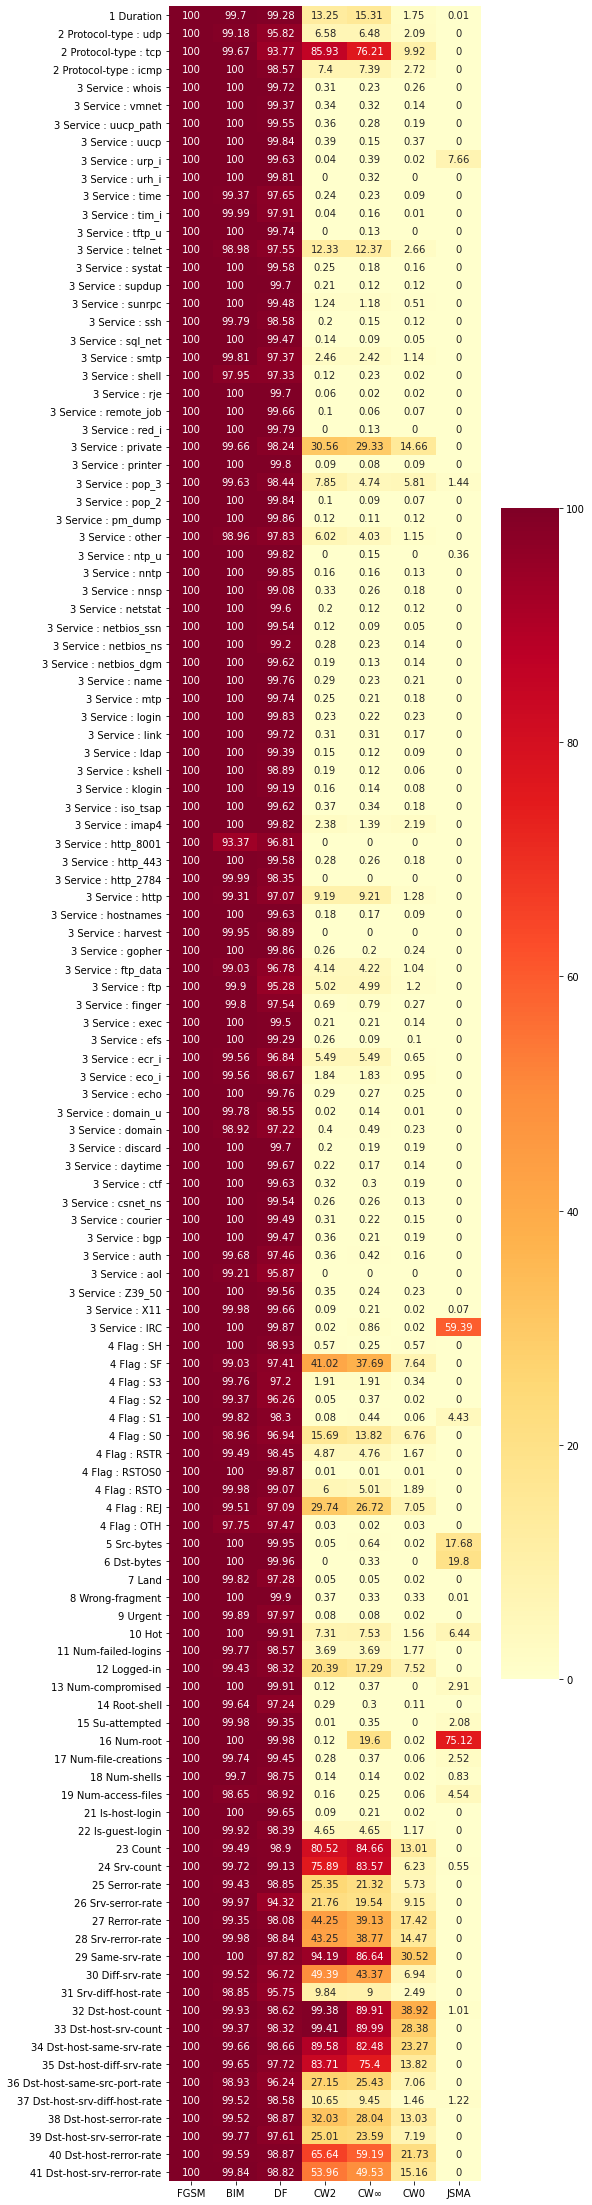

In [ ]:
fig, ax = plt.subplots(figsize=(7,40))

sb.heatmap(adv_feat_stats.round(decimals=2), annot=True, cmap='YlOrRd', fmt='g')

plt.savefig("hmap_features_stats.eps", format="eps", bbox_inches='tight')
plt.show()

In [ ]:
adv_inv.to_csv("./adv_inv")
adv_inv

,Clean,FGSM,BIM,DF,CW2,CW∞,CW0,JSMA
Invalid value range,0.0,100.0,100.0,100.0,94.708953,80.534559,63.539313,0.015585
Invalid binary values,0.0,100.0,100.0,100.0,99.968830,90.080262,54.055950,67.295254
Invalid class belonging,0.0,100.0,100.0,100.0,0.000000,0.849373,0.163641,67.279670


## Features analysis

### Heat map of the correlation matrix

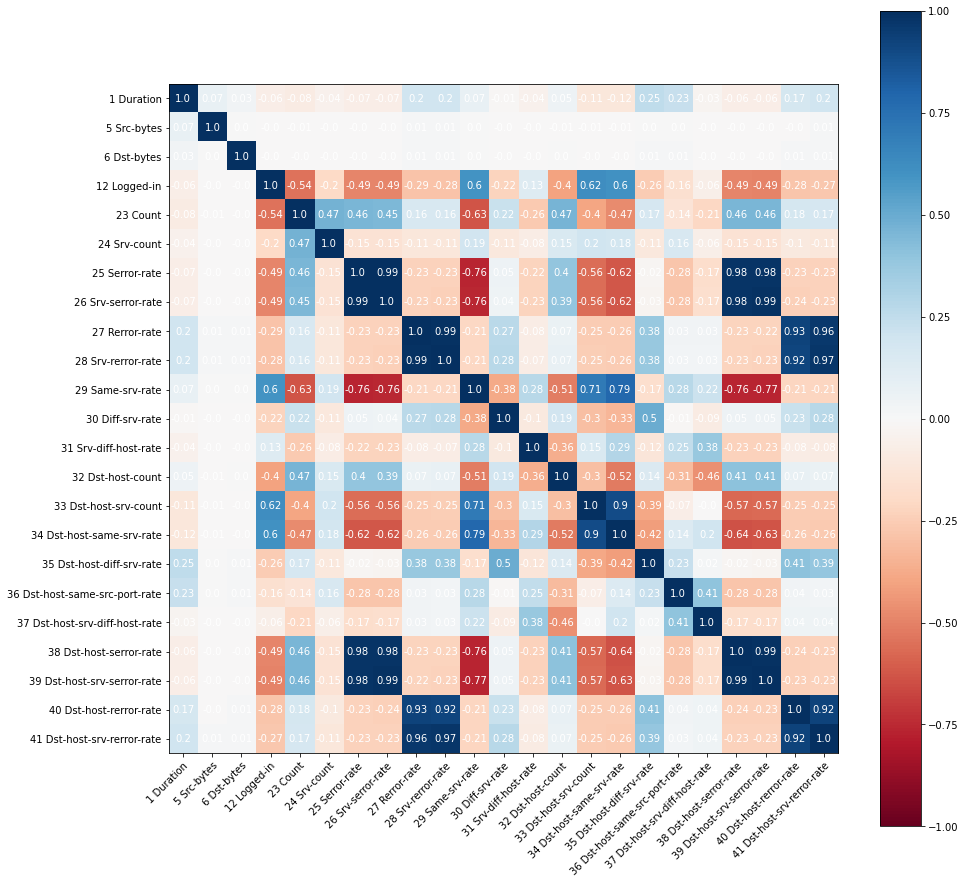

In [ ]:
numeric_features =['1 Duration', '5 Src-bytes', '6 Dst-bytes', '12 Logged-in', '23 Count', '24 Srv-count', '25 Serror-rate', '26 Srv-serror-rate', '27 Rerror-rate', '28 Srv-rerror-rate', '29 Same-srv-rate', '30 Diff-srv-rate', '31 Srv-diff-host-rate', '32 Dst-host-count', '33 Dst-host-srv-count', '34 Dst-host-same-srv-rate', '35 Dst-host-diff-srv-rate', '36 Dst-host-same-src-port-rate', '37 Dst-host-srv-diff-host-rate', '38 Dst-host-serror-rate', '39 Dst-host-srv-serror-rate', '40 Dst-host-rerror-rate', '41 Dst-host-srv-rerror-rate']
corr = df_training[numeric_features].corr()

fig, ax = plt.subplots(figsize=(15,15))
im = ax.imshow(corr, cmap='RdBu', vmin=-1, vmax=1)

ax.figure.colorbar(im)
plt.yticks(np.arange(0, len(corr.columns), 1), corr.columns)
plt.xticks(np.arange(0, len(corr.columns), 1), corr.columns, rotation=45, ha="right", rotation_mode="anchor")

for i in range(len(numeric_features)):
    for j in range(len(numeric_features)):
        text = ax.text(j, i, corr.iloc[i, j].round(decimals=2), ha="center", va="center", color="w")
        
plt.savefig('correlation_matrix.eps', format='eps', bbox_inches='tight')  
plt.show()

### Principal Compononent Analysis

Explained variance fo each principal component : 
  1  41.249065
  2  15.650716
  3  10.941839
  4   5.073433
  5   4.106070
  6   2.822200
  7   2.268747
  8   1.979810
  9   1.497864
 10   1.378570
Correlation between components and features :
                              0            1            2            3   sum
               21 Is-host-login  1.10295e-06  9.83614e-07  7.93102e-07  0.00
                       9 Urgent  1.26554e-05  8.41149e-07  2.80779e-06  0.00
                    16 Num-root  1.19544e-05  4.89381e-06  8.62628e-06  0.00
             13 Num-compromised  1.11822e-05  5.10656e-06  9.37069e-06  0.00
          3 Service : http_2784  3.22078e-06   2.7586e-05  9.28536e-06  0.00
                    6 Dst-bytes  4.01553e-07  3.97206e-05  6.04742e-06  0.00
            3 Service : pm_dump  1.66014e-06  3.99401e-05  1.49354e-05  0.00
          3 Service : http_8001  1.07368e-05  3.47323e-05  1.22219e-05  0.00
            3 Service : harvest  1.05969e-05  3.49707e-05  1.

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


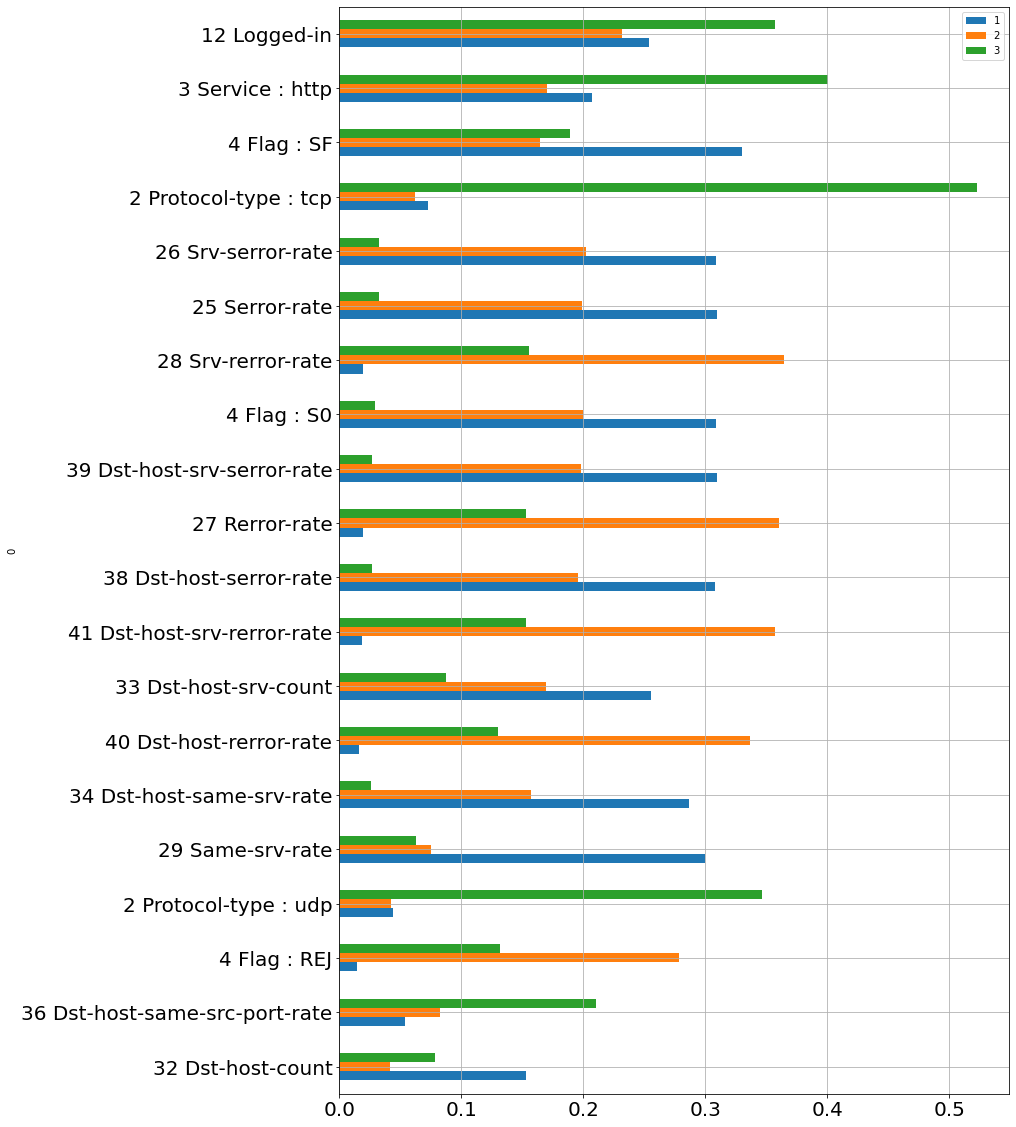

In [ ]:
n_components=10
pca = PCA(n_components)
principalComponents = pca.fit_transform(df_training.iloc[:, :121])
print("Explained variance fo each principal component : ")
print(pd.DataFrame(enumerate(pca.explained_variance_ratio_*100, 1)).to_string(index=False, header=False))
n_components=3
pca = PCA(n_components)
principalComponents = pca.fit_transform(df_training.iloc[:, :121])
principalDf = pd.DataFrame(data = principalComponents, columns = list(range(1, n_components+1)))
print("Correlation between components and features :")
corr_comp_feat = pd.DataFrame(data=np.hstack([df_training.columns[:121].values.reshape([121,1]), np.abs(pca.components_.T)]), columns = list(range(n_components+1)))
#plt.figure(num=None, figsize=(5, 30), dpi=80, facecolor='w', edgecolor='k');
#plt.barh(corr_comp_feat['Feature'], corr_comp_feat['PC1'].abs(), corr_comp_feat['PC2'].abs());
#plt.xticks(rotation=90);
corr_comp_feat['sum'] = corr_comp_feat[list(range(1, n_components+1))].sum(axis=1)
corr_comp_feat = corr_comp_feat.sort_values('sum', ascending=True)
#corr_comp_feat = corr_comp_feat.sort_values(by=list(range(1, n_components+1)))
print(corr_comp_feat.round(decimals=2).to_string(index=False))
ax = corr_comp_feat.iloc[-20:, :].plot(x=0, y=list(range(1, n_components+1)), kind="barh", grid=True, figsize=(12,20), fontsize=20);
fig = ax.get_figure()
plt.savefig('pca.eps', format='eps', bbox_inches='tight') 

### Chi-2 independence test

                                Chi-2 Score
24 Srv-count                           0.03
3 Service : tim_i                      0.26
11 Num-failed-logins                   0.59
9 Urgent                               0.61
21 Is-host-login                       0.87
3 Service : ftp                        0.89
3 Service : http_2784                  1.15
6 Dst-bytes                            1.33
3 Service : harvest                    2.30
3 Service : http_8001                  2.30
3 Service : aol                        2.30
5 Src-bytes                            2.42
3 Service : tftp_u                     2.61
13 Num-compromised                     3.60
16 Num-root                            4.36
3 Service : pm_dump                    5.74
10 Hot                                 6.33
7 Land                                 6.51
18 Num-shells                          6.74
3 Service : red_i                      6.96
3 Service : urh_i                      8.71
4 Flag : OTH                    

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


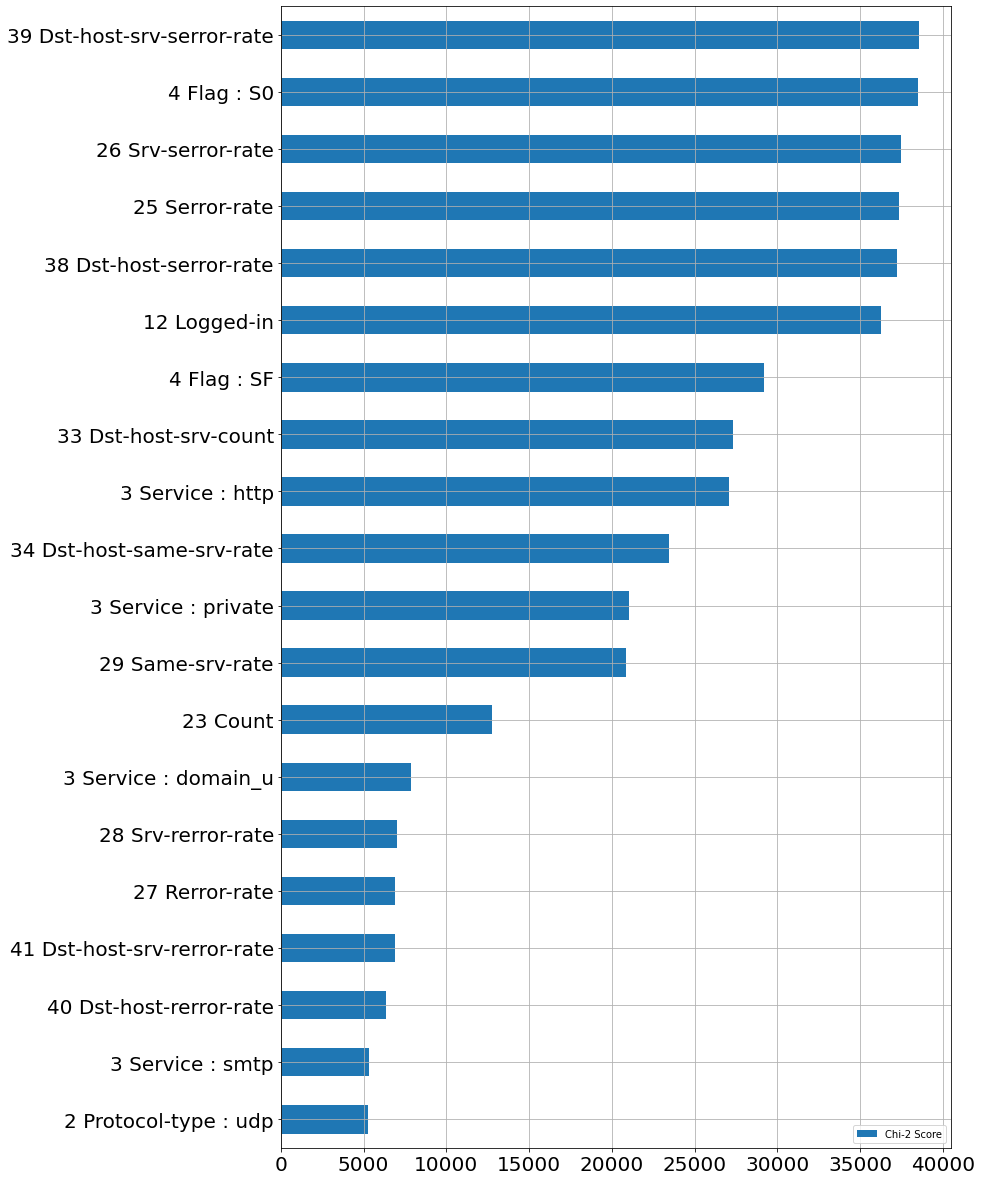

In [ ]:
chi2_results = chi2(df_training.iloc[:, :121], df_training.iloc[:, 121:])
chi2_scores = pd.DataFrame(data=chi2_results, columns=df_training.columns[:-1], index=['Chi-2 Score', 'P']).T
chi2_scores = pd.DataFrame(chi2_scores['Chi-2 Score'])
chi2_scores = chi2_scores.sort_values(['Chi-2 Score'], ascending=True)
print(chi2_scores.round(decimals=2))
ax = chi2_scores.iloc[-20:, :].plot( kind="barh", grid=True, figsize=(12,21), fontsize=20)
fig = ax.get_figure()
plt.savefig('chi2.eps', format='eps', bbox_inches='tight') 

### Proportion of commun features in PCA and Chi-2

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


            0
1    0.000000
2    0.000000
3    0.000000
4    0.000000
5    0.200000
6    0.500000
7    0.571429
8    0.625000
9    0.777778
10   0.700000
11   0.727273
12   0.666667
13   0.692308
14   0.642857
15   0.733333
16   0.812500
17   0.823529
18   0.833333
19   0.789474
20   0.800000
21   0.809524
22   0.863636
23   0.913043
24   0.916667
25   0.920000
26   0.923077
27   0.888889
28   0.857143
29   0.862069
30   0.866667
31   0.870968
32   0.875000
33   0.878788
34   0.852941
35   0.857143
36   0.861111
37   0.864865
38   0.842105
39   0.820513
40   0.800000
41   0.780488
42   0.785714
43   0.813953
44   0.818182
45   0.800000
46   0.804348
47   0.808511
48   0.812500
49   0.816327
50   0.820000
51   0.823529
52   0.826923
53   0.830189
54   0.833333
55   0.836364
56   0.839286
57   0.859649
58   0.862069
59   0.864407
60   0.866667
61   0.868852
62   0.870968
63   0.873016
64   0.859375
65   0.861538
66   0.863636
67   0.865672
68   0.852941
69   0.855072
70   0.871429
71   0

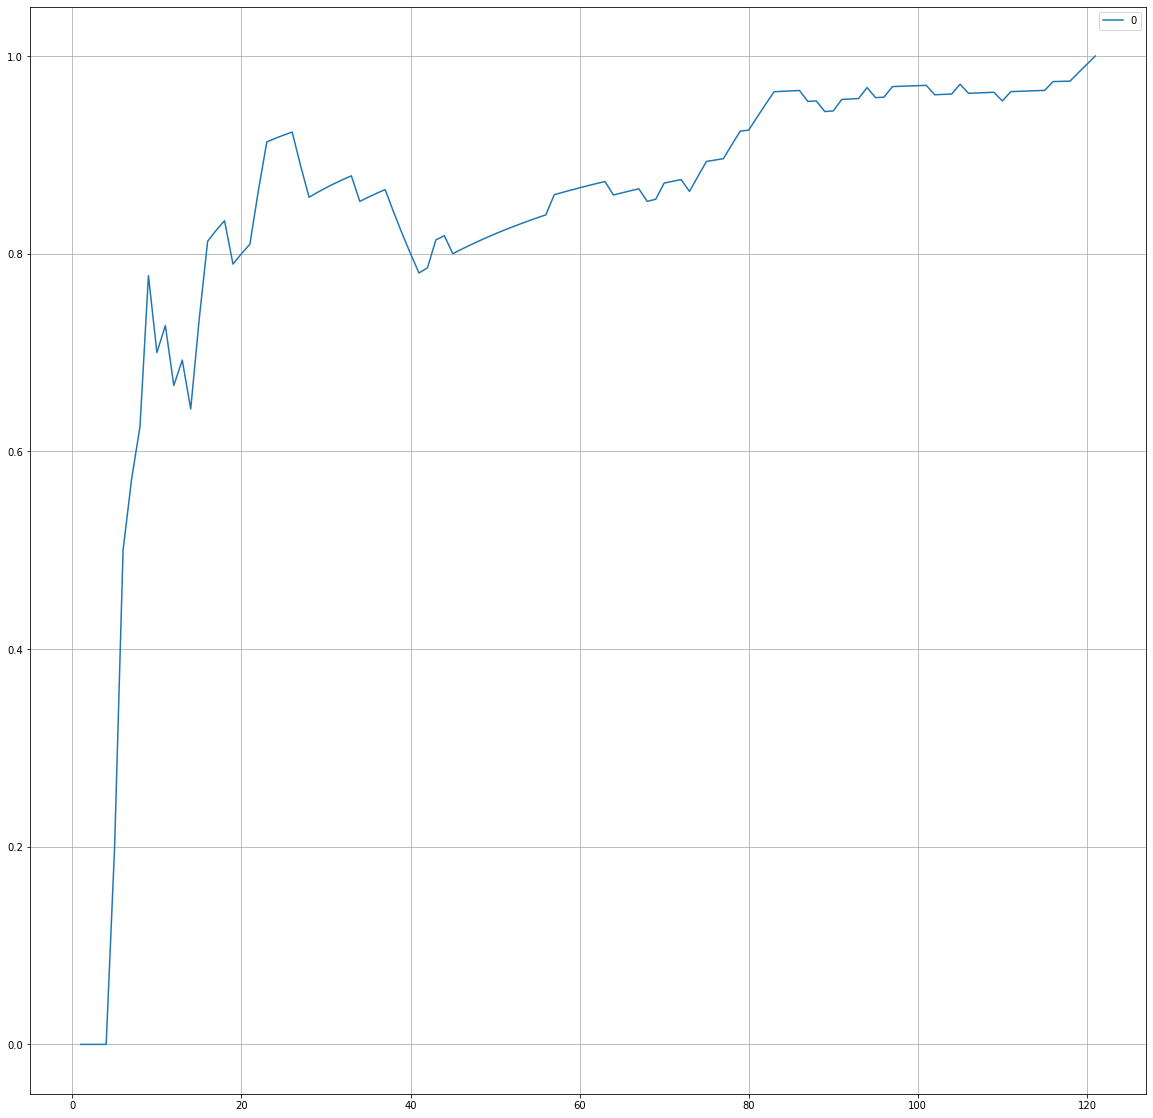

In [ ]:
keepit = []
for max in reversed(range(-121, 0)):
    commun = 0
    for i in chi2_scores.iloc[max:, :].index:
        if i in list(corr_comp_feat.iloc[max:, 0]):
            commun += 1            
    keepit.append(commun/max*-1)
df = pd.DataFrame(keepit, index=list(range(1,122)))
ax = df.plot(grid=True, figsize=(20,20))
fig = ax.get_figure()
plt.savefig('pca_chi2.eps', format='eps', bbox_inches='tight') 

df.round(decimals=3).T
print(df)

## Contributions to Adversarial Robustness Toolbox library

### Carlini&Wagner L0-attack [implemented]

In [ ]:
# MIT License
#
# Copyright (C) The Adversarial Robustness Toolbox (ART) Authors 2018
#
# Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated
# documentation files (the "Software"), to deal in the Software without restriction, including without limitation the
# rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit
# persons to whom the Software is furnished to do so, subject to the following conditions:
#
# The above copyright notice and this permission notice shall be included in all copies or substantial portions of the
# Software.
#
# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE
# WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
# AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT,
# TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
# SOFTWARE.
"""
This module implements the L2 and LInf optimized attacks `CarliniL2Method` and `CarliniLInfMethod` of Carlini and Wagner
(2016). These attacks are among the most effective white-box attacks and should be used among the primary attacks to
evaluate potential defences. A major difference with respect to the original implementation
(https://github.com/carlini/nn_robust_attacks) is that this implementation uses line search in the optimization of the
attack objective.

| Paper link: https://arxiv.org/abs/1608.04644
"""
from __future__ import absolute_import, division, print_function, unicode_literals

import logging

import numpy as np

from art.config import ART_NUMPY_DTYPE
from art.estimators.estimator import BaseEstimator
from art.estimators.classification.classifier import ClassGradientsMixin
from art.attacks.attack import EvasionAttack
from art.utils import compute_success, get_labels_np_array, tanh_to_original, original_to_tanh
from art.utils import check_and_transform_label_format

logger = logging.getLogger(__name__)

class CarliniL0Method(EvasionAttack):
    """
    The L_0 distance metric is non-differentiable and therefore is ill-suited for standard gradient descent.
    Instead, we use an iterative algorithm that, in each iteration, identifies some pixels that don’t have much effect
    on the classifier output and then fixes those pixels, so their value will never be changed. The set of fixed pixels
    grows in each iteration until we have, by process of elimination, identified a minimal (but possibly not minimum)
    subset of pixels that can be modified to generate an adversarial example. In each iteration, we use our L_2 attack
    to identify which pixels are unimportant.

    | Paper link: https://arxiv.org/abs/1608.04644
    """

    attack_params = EvasionAttack.attack_params + [
        "confidence",
        "targeted",
        "learning_rate",
        "max_iter",
        "binary_search_steps",
        "initial_const",
        "mask",
        "warm_start",
        "max_halving",
        "max_doubling",
        "batch_size",
    ]

    _estimator_requirements = (BaseEstimator, ClassGradientsMixin)

    def __init__(
        self,
        classifier,
        confidence=0.0,
        targeted=False,
        learning_rate=0.01,
        binary_search_steps=10,
        max_iter=10,
        initial_const=0.01,
        mask=None,
        #warm_start=True, # For later implementation of warm_start
        max_halving=5,
        max_doubling=5,
        batch_size=1,
    ):
        """
        Create a Carlini L_0 attack instance.

        :param classifier: A trained classifier.
        :type classifier: :class:`.Classifier`
        :param confidence: Confidence of adversarial examples: a higher value produces examples that are farther away,
                from the original input, but classified with higher confidence as the target class.
        :type confidence: `float`
        :param targeted: Should the attack target one specific class.
        :type targeted: `bool`
        :param learning_rate: The initial learning rate for the attack algorithm. Smaller values produce better results
                but are slower to converge.
        :type learning_rate: `float`
        :param binary_search_steps: Number of times to adjust constant with binary search (positive value). If
                                    `binary_search_steps` is large, then the algorithm is not very sensitive to the
                                    value of `initial_const`. Note that the values gamma=0.999999 and c_upper=10e10 are
                                    hardcoded with the same values used by the authors of the method.
        :type binary_search_steps: `int`
        :param max_iter: The maximum number of iterations.
        :type max_iter: `int`
        :param initial_const: The initial trade-off constant `c` to use to tune the relative importance of distance and
                confidence. If `binary_search_steps` is large, the initial constant is not important, as discussed in
                Carlini and Wagner (2016).
        :type initial_const: `float`
        :param mask: The initial features that can be modified by the algorithm. If not specified, the
                algorithm uses the full feature set.
        :type mask: `np.ndarray`
        :param warm_start: Instead of starting gradien descent in each iteration from the initial image. we start the
                gradient descent from the solution found on the previous iteration.
        :type warm_start: `boolean`
        :param max_halving: Maximum number of halving steps in the line search optimization.
        :type max_halving: `int`
        :param max_doubling: Maximum number of doubling steps in the line search optimization.
        :type max_doubling: `int`
        :param batch_size: Size of the batch on which adversarial samples are generated.
        :type batch_size: `int`
        """
        super(CarliniL0Method, self).__init__(estimator=classifier)

        kwargs = {
            "confidence": confidence,
            "targeted": targeted,
            "learning_rate": learning_rate,
            "binary_search_steps": binary_search_steps,
            "max_iter": max_iter,
            "initial_const": initial_const,
            "mask": mask,
            #"warm_start": warm_start, # For later implementation of warm_start
            "max_halving": max_halving,
            "max_doubling": max_doubling,
            "batch_size": batch_size,
        }
        assert self.set_params(**kwargs)

        # There are internal hyperparameters:
        # Abort binary search for c if it exceeds this threshold (suggested in Carlini and Wagner (2016)):
        self._c_upper_bound = 10e10

        # Smooth arguments of arctanh by multiplying with this constant to avoid division by zero.
        # It appears this is what Carlini and Wagner (2016) are alluding to in their footnote 8. However, it is not
        # clear how their proposed trick ("instead of scaling by 1/2 we scale by 1/2 + eps") works in detail.
        self._tanh_smoother = 0.999999

        # The tanh transformation does not always map inputs back to their original values event if they're unmodified
        # To overcom this problem, we set a threshold of minimal diffrence considered as perturbation
        # Below this threshold, a diffrence between values is considered as tanh transformation diffrence
        self._perturbation_threshold = 1e-06

    def _loss(self, x, x_adv, target, c_weight):
        """
        Compute the objective function value.

        :param x: An array with the original input.
        :type x: `np.ndarray`
        :param x_adv: An array with the adversarial input.
        :type x_adv: `np.ndarray`
        :param target: An array with the target class (one-hot encoded).
        :type target: `np.ndarray`
        :param c_weight: Weight of the loss term aiming for classification as target.
        :type c_weight: `float`
        :return: A tuple holding the current logits, l2 distance and overall loss.
        :rtype: `(float, float, float)`
        """
        l2dist = np.sum(np.square(x - x_adv).reshape(x.shape[0], -1), axis=1)
        z_predicted = self.estimator.predict(
            np.array(x_adv, dtype=ART_NUMPY_DTYPE), logits=True, batch_size=self.batch_size
        )
        z_target = np.sum(z_predicted * target, axis=1)
        z_other = np.max(z_predicted * (1 - target) + (np.min(z_predicted, axis=1) - 1)[:, np.newaxis] * target, axis=1)

        # The following differs from the exact definition given in Carlini and Wagner (2016). There (page 9, left
        # column, last equation), the maximum is taken over Z_other - Z_target (or Z_target - Z_other respectively)
        # and -confidence. However, it doesn't seem that that would have the desired effect (loss term is <= 0 if and
        # only if the difference between the logit of the target and any other class differs by at least confidence).
        # Hence the rearrangement here.

        if self.targeted:
            # if targeted, optimize for making the target class most likely
            loss = np.maximum(z_other - z_target + self.confidence, np.zeros(x.shape[0]))
        else:
            # if untargeted, optimize for making any other class most likely
            loss = np.maximum(z_target - z_other + self.confidence, np.zeros(x.shape[0]))

        return z_predicted, l2dist, c_weight * loss + l2dist

    def _loss_gradient(self, z_logits, target, x, x_adv, x_adv_tanh, c_weight, clip_min, clip_max):
        """
        Compute the gradient of the loss function.

        :param z_logits: An array with the current logits.
        :type z_logits: `np.ndarray`
        :param target: An array with the target class (one-hot encoded).
        :type target: `np.ndarray`
        :param x: An array with the original input.
        :type x: `np.ndarray`
        :param x_adv: An array with the adversarial input.
        :type x_adv: `np.ndarray`
        :param x_adv_tanh: An array with the adversarial input in tanh space.
        :type x_adv_tanh: `np.ndarray`
        :param c_weight: Weight of the loss term aiming for classification as target.
        :type c_weight: `float`
        :param clip_min: Minimum clipping value.
        :type clip_min: `float`
        :param clip_max: Maximum clipping value.
        :type clip_max: `float`
        :return: An array with the gradient of the loss function.
        :type target: `np.ndarray`
        """
        if self.targeted:
            i_sub = np.argmax(target, axis=1)
            i_add = np.argmax(z_logits * (1 - target) + (np.min(z_logits, axis=1) - 1)[:, np.newaxis] * target, axis=1)
        else:
            i_add = np.argmax(target, axis=1)
            i_sub = np.argmax(z_logits * (1 - target) + (np.min(z_logits, axis=1) - 1)[:, np.newaxis] * target, axis=1)

        loss_gradient = self.estimator.class_gradient(x_adv, label=i_add)
        loss_gradient -= self.estimator.class_gradient(x_adv, label=i_sub)
        loss_gradient = loss_gradient.reshape(x.shape)

        c_mult = c_weight
        for _ in range(len(x.shape) - 1):
            c_mult = c_mult[:, np.newaxis]

        loss_gradient *= c_mult
        loss_gradient += 2 * (x_adv - x)
        loss_gradient *= clip_max - clip_min
        loss_gradient *= (1 - np.square(np.tanh(x_adv_tanh))) / (2 * self._tanh_smoother)

        return loss_gradient


    def generate(self, x, y=None, **kwargs):
        """
        Generate adversarial samples and return them in an array.

        :param x: An array with the original inputs to be attacked.
        :type x: `np.ndarray`
        :param y: Target values (class labels) one-hot-encoded of shape (nb_samples, nb_classes) or indices of shape
                  (nb_samples,). If `self.targeted` is true, then `y` represents the target labels. If `self.targeted`
                  is true, then `y_val` represents the target labels. Otherwise, the targets are the original class
                  labels.
        :return: An array holding the adversarial examples.
        :rtype: `np.ndarray`
        """
        y = check_and_transform_label_format(y, self.estimator.nb_classes)
        x_adv = x.astype(ART_NUMPY_DTYPE)

        if self.estimator.clip_values is not None:
            clip_min, clip_max = self.estimator.clip_values
        else:
            clip_min, clip_max = np.amin(x), np.amax(x)

        # Assert that, if attack is targeted, y_val is provided:
        if self.targeted and y is None:
            raise ValueError("Target labels `y` need to be provided for a targeted attack.")

        # No labels provided, use model prediction as correct class
        if y is None:
            y = get_labels_np_array(self.estimator.predict(x, batch_size=self.batch_size))

        if self.mask is None:
            # No initial activation provided, use the full feature set
            activation = np.ones(x.shape)
        else:
            # Check if the initial activation has the same dimension as the input data
            if self.mask.shape != x.shape:
                raise ValueError("The mask must have the same dimensions as the input data.")
            activation = np.array(self.mask).astype(float)

        # L_0 attack specific variables
        final_adversarial_example = x.astype(ART_NUMPY_DTYPE)
        old_activation = activation.copy()
        c_final = np.ones(x.shape[0])
        best_l0dist = np.inf * np.ones(x.shape[0])

        # Main loop of the L_0 attack.
        # For each iteration :
        #   - Calls the L_2 attack to compute an adversarial example
        #   - Computes the gradients of the objective function evaluated at the adversarial instance
        #   - Fix the attribute with the lowest value (gradient * perturbation)
        # Repeat until the L_2 attack fails to find an adversarial examples.
        while True:
            # Compute perturbation with implicit batching
            nb_batches = int(np.ceil(x_adv.shape[0] / float(self.batch_size)))
            for batch_id in range(nb_batches):
                logger.debug("Processing batch %i out of %i", batch_id, nb_batches)

                batch_index_1, batch_index_2 = batch_id * self.batch_size, (batch_id + 1) * self.batch_size
                #x_batch = x[batch_index_1:batch_index_2]
                x_batch = x_adv[batch_index_1:batch_index_2] #use for future implementation of warm_start
                y_batch = y[batch_index_1:batch_index_2]
                activation_batch = activation[batch_index_1:batch_index_2]

                # The optimization is performed in tanh space to keep the adversarial images bounded in correct range
                x_batch_tanh = original_to_tanh(x_batch, clip_min, clip_max, self._tanh_smoother)

                # Initialize binary search:
                c_current = self.initial_const * np.ones(x_batch.shape[0])
                c_lower_bound = np.zeros(x_batch.shape[0])
                c_double = np.ones(x_batch.shape[0]) > 0

                # Initialize placeholders for best l2 distance and attack found so far
                best_l2dist = np.inf * np.ones(x_batch.shape[0])
                best_l0dist_batch = np.inf * np.ones(x_batch.shape[0])
                best_x_adv_batch = x_batch.copy()

                for bss in range(self.binary_search_steps):
                    logger.debug(
                        "Binary search step %i out of %i (c_mean==%f)", bss, self.binary_search_steps, np.mean(c_current)
                    )
                    nb_active = int(np.sum(c_current < self._c_upper_bound))
                    logger.debug(
                        "Number of samples with c_current < _c_upper_bound: %i out of %i", nb_active, x_batch.shape[0]
                    )
                    if nb_active == 0:
                        break
                    learning_rate = self.learning_rate * np.ones(x_batch.shape[0])

                    # Initialize perturbation in tanh space:
                    x_adv_batch = x_batch.copy()
                    x_adv_batch_tanh = x_batch_tanh.copy()

                    z_logits, l2dist, loss = self._loss(x_batch, x_adv_batch, y_batch, c_current)
                    attack_success = loss - l2dist <= 0
                    overall_attack_success = attack_success

                    for i_iter in range(self.max_iter):
                        logger.debug("Iteration step %i out of %i", i_iter, self.max_iter)
                        logger.debug("Average Loss: %f", np.mean(loss))
                        logger.debug("Average L2Dist: %f", np.mean(l2dist))
                        logger.debug("Average Margin Loss: %f", np.mean(loss - l2dist))
                        logger.debug(
                            "Current number of succeeded attacks: %i out of %i",
                            int(np.sum(attack_success)),
                            len(attack_success),
                        )

                        l0dist = np.sum((np.abs(x_batch - x_adv_batch) > self._perturbation_threshold).astype(int), axis=1)
                        improved_adv = attack_success & (l0dist < best_l0dist_batch)
                        logger.debug("Number of improved L0 distances: %i", int(np.sum(improved_adv)))
                        if np.sum(improved_adv) > 0:
                            best_l0dist_batch[improved_adv] = l0dist[improved_adv]
                            best_x_adv_batch[improved_adv] = x_adv_batch[improved_adv]

                        active = (c_current < self._c_upper_bound) & (learning_rate > 0)
                        nb_active = int(np.sum(active))
                        logger.debug(
                            "Number of samples with c_current < _c_upper_bound and learning_rate > 0: %i out of %i",
                            nb_active,
                            x_batch.shape[0],
                        )
                        if nb_active == 0:
                            break

                        # compute gradient:
                        logger.debug("Compute loss gradient")
                        perturbation_tanh = -self._loss_gradient(
                            z_logits[active],
                            y_batch[active],
                            x_batch[active],
                            x_adv_batch[active],
                            x_adv_batch_tanh[active],
                            c_current[active],
                            clip_min,
                            clip_max,
                        )

                        # perform line search to optimize perturbation
                        # first, halve the learning rate until perturbation actually decreases the loss:
                        prev_loss = loss.copy()
                        best_loss = loss.copy()
                        best_lr = np.zeros(x_batch.shape[0])
                        halving = np.zeros(x_batch.shape[0])

                        for i_halve in range(self.max_halving):
                            logger.debug("Perform halving iteration %i out of %i", i_halve, self.max_halving)
                            do_halving = loss[active] >= prev_loss[active]
                            logger.debug("Halving to be performed on %i samples", int(np.sum(do_halving)))
                            if np.sum(do_halving) == 0:
                                break
                            active_and_do_halving = active.copy()
                            active_and_do_halving[active] = do_halving

                            lr_mult = learning_rate[active_and_do_halving]
                            for _ in range(len(x.shape) - 1):
                                lr_mult = lr_mult[:, np.newaxis]

                            x_adv1 = x_adv_batch_tanh[active_and_do_halving]
                            new_x_adv_batch_tanh = x_adv1 + lr_mult * perturbation_tanh[do_halving] * activation_batch[do_halving]
                            new_x_adv_batch = tanh_to_original(new_x_adv_batch_tanh, clip_min, clip_max)
                            _, l2dist[active_and_do_halving], loss[active_and_do_halving] = self._loss(
                                x_batch[active_and_do_halving],
                                new_x_adv_batch,
                                y_batch[active_and_do_halving],
                                c_current[active_and_do_halving],
                            )

                            logger.debug("New Average Loss: %f", np.mean(loss))
                            logger.debug("New Average L2Dist: %f", np.mean(l2dist))
                            logger.debug("New Average Margin Loss: %f", np.mean(loss - l2dist))

                            best_lr[loss < best_loss] = learning_rate[loss < best_loss]
                            best_loss[loss < best_loss] = loss[loss < best_loss]
                            learning_rate[active_and_do_halving] /= 2
                            halving[active_and_do_halving] += 1
                        learning_rate[active] *= 2

                        # if no halving was actually required, double the learning rate as long as this
                        # decreases the loss:
                        for i_double in range(self.max_doubling):
                            logger.debug("Perform doubling iteration %i out of %i", i_double, self.max_doubling)
                            do_doubling = (halving[active] == 1) & (loss[active] <= best_loss[active])
                            logger.debug("Doubling to be performed on %i samples", int(np.sum(do_doubling)))
                            if np.sum(do_doubling) == 0:
                                break
                            active_and_do_doubling = active.copy()
                            active_and_do_doubling[active] = do_doubling
                            learning_rate[active_and_do_doubling] *= 2

                            lr_mult = learning_rate[active_and_do_doubling]
                            for _ in range(len(x.shape) - 1):
                                lr_mult = lr_mult[:, np.newaxis]

                            x_adv2 = x_adv_batch_tanh[active_and_do_doubling]
                            new_x_adv_batch_tanh = x_adv2 + lr_mult * perturbation_tanh[do_doubling] * activation_batch[do_doubling]
                            new_x_adv_batch = tanh_to_original(new_x_adv_batch_tanh, clip_min, clip_max)
                            _, l2dist[active_and_do_doubling], loss[active_and_do_doubling] = self._loss(
                                x_batch[active_and_do_doubling],
                                new_x_adv_batch,
                                y_batch[active_and_do_doubling],
                                c_current[active_and_do_doubling],
                            )
                            logger.debug("New Average Loss: %f", np.mean(loss))
                            logger.debug("New Average L2Dist: %f", np.mean(l2dist))
                            logger.debug("New Average Margin Loss: %f", np.mean(loss - l2dist))
                            best_lr[loss < best_loss] = learning_rate[loss < best_loss]
                            best_loss[loss < best_loss] = loss[loss < best_loss]

                        learning_rate[halving == 1] /= 2

                        update_adv = best_lr[active] > 0
                        logger.debug("Number of adversarial samples to be finally updated: %i", int(np.sum(update_adv)))

                        if np.sum(update_adv) > 0:
                            active_and_update_adv = active.copy()
                            active_and_update_adv[active] = update_adv
                            best_lr_mult = best_lr[active_and_update_adv]
                            for _ in range(len(x.shape) - 1):
                                best_lr_mult = best_lr_mult[:, np.newaxis]

                            x_adv4 = x_adv_batch_tanh[active_and_update_adv]
                            best_lr1 = best_lr_mult * perturbation_tanh[update_adv]
                            x_adv_batch_tanh[active_and_update_adv] = x_adv4 + best_lr1 * activation_batch[active_and_update_adv]

                            x_adv6 = x_adv_batch_tanh[active_and_update_adv]
                            x_adv_batch[active_and_update_adv] = tanh_to_original(x_adv6, clip_min, clip_max)
                            (
                                z_logits[active_and_update_adv],
                                l2dist[active_and_update_adv],
                                loss[active_and_update_adv],
                            ) = self._loss(
                                x_batch[active_and_update_adv],
                                x_adv_batch[active_and_update_adv],
                                y_batch[active_and_update_adv],
                                c_current[active_and_update_adv],
                            )
                            attack_success = loss - l2dist <= 0
                            overall_attack_success = overall_attack_success | attack_success

                    # Update depending on attack success:
                    l0dist = np.sum((np.abs(x_batch - x_adv_batch) > self._perturbation_threshold).astype(int), axis=1)
                    improved_adv = attack_success & (l0dist < best_l0dist_batch)
                    logger.debug("Number of improved L0 distances: %i", int(np.sum(improved_adv)))
                    if np.sum(improved_adv) > 0:
                        best_l0dist_batch[improved_adv] = l0dist[improved_adv]
                        best_x_adv_batch[improved_adv] = x_adv_batch[improved_adv]

                    c_double[overall_attack_success] = False
                    c_current[overall_attack_success] = (c_lower_bound + c_current)[overall_attack_success] / 2

                    c_old = c_current
                    c_current[~overall_attack_success & c_double] *= 2

                    c_current1 = (c_current - c_lower_bound)[~overall_attack_success & ~c_double]
                    c_current[~overall_attack_success & ~c_double] += c_current1 / 2
                    c_lower_bound[~overall_attack_success] = c_old[~overall_attack_success]

                c_final[batch_index_1:batch_index_2] = c_current
                x_adv[batch_index_1:batch_index_2] = best_x_adv_batch

            logger.info(
                "Success rate of C&W L_2 attack: %.2f%%",
                100 * compute_success(self.estimator, x, y, x_adv, self.targeted, batch_size=self.batch_size),
            )

            # If the L_2 attack can't find any adversarial examples with the new activation, return the last one
            z_logits, l2dist, loss = self._loss(x, x_adv, y, c_final)
            attack_success = loss - l2dist <= 0
            #l0dist = np.sum((np.abs(x_batch - x_adv_batch) > self._perturbation_threshold).astype(int), axis=1)
            l0dist = np.sum((np.abs(x - x_adv) > self._perturbation_threshold).astype(int), axis=1)
            improved_adv = attack_success & (l0dist < best_l0dist)
            if np.sum(improved_adv) > 0:
                final_adversarial_example[improved_adv] = x_adv[improved_adv]
            else:
                return x*(old_activation == 0).astype(int) + final_adversarial_example*old_activation

            # Compute the gradients of the objective function evaluated at the adversarial instance
            x_adv_tanh = original_to_tanh(x_adv, clip_min, clip_max, self._tanh_smoother)
            objective_loss_gradient = -self._loss_gradient(
                z_logits,
                y,
                x,
                x_adv,
                x_adv_tanh,
                c_final,
                clip_min,
                clip_max,
            )
            perturbation_L1_norm = np.abs(x_adv - x)

            # gradient * perturbation tells how much reduction to the objective function we obtain for each attribute
            objective_reduction = np.abs(objective_loss_gradient) * perturbation_L1_norm

            # Put a huge nomber as objective_reduction value for fixed feature (in order not to select them again)
            # was np.inf before, but inf * 0 = nan
            objective_reduction += 999999999999999 * (activation == 0).astype(int)

            # Fix the feature with the lowest objective_reduction value (only for the examples that succeeded)
            fix_feature_index = np.argmin(objective_reduction, axis=1)
            fix_feature = np.ones(x.shape)
            fix_feature[np.arange(fix_feature_index.size), fix_feature_index] = 0
            old_activation[improved_adv]  = activation.copy()[improved_adv]
            activation[improved_adv]  *= fix_feature[improved_adv]
            print(
                "L0 norm before fixing :\n{}\nNumber active features :\n{}\nIndex of fixed feature :\n{}"
                .format(
                    np.sum((perturbation_L1_norm > self._perturbation_threshold).astype(int), axis=1),
                    np.sum(activation, axis=1),
                    fix_feature_index
                )
            )

    def set_params(self, **kwargs):
        """Take in a dictionary of parameters and applies attack-specific checks before saving them as attributes.

        :param confidence: Confidence of adversarial examples: a higher value produces examples that are farther away,
               from the original input, but classified with higher confidence as the target class.
        :type confidence: `float`
        :param targeted: Should the attack target one specific class
        :type targeted: `bool`
        :param learning_rate: The learning rate for the attack algorithm. Smaller values produce better results but are
               slower to converge.
        :type learning_rate: `float`
        :param binary_search_steps: number of times to adjust constant with binary search (positive value)
        :type binary_search_steps: `int`
        :param max_iter: The maximum number of iterations.
        :type max_iter: `int`
        :param initial_const: (optional float, positive) The initial trade-off constant c to use to tune the relative
               importance of distance and confidence. If binary_search_steps is large,
               the initial constant is not important. The default value 1e-4 is suggested in Carlini and Wagner (2016).
        :type initial_const: `float`
        :param max_halving: Maximum number of halving steps in the line search optimization.
        :type max_halving: `int`
        :param max_doubling: Maximum number of doubling steps in the line search optimization.
        :type max_doubling: `int`
        :param batch_size: Internal size of batches on which adversarial samples are generated.
        :type batch_size: `int`
        """
        # Save attack-specific parameters
        super(CarliniL0Method, self).set_params(**kwargs)

        if not isinstance(self.binary_search_steps, (int, np.int)) or self.binary_search_steps < 0:
            raise ValueError("The number of binary search steps must be a non-negative integer.")

        if not isinstance(self.max_iter, (int, np.int)) or self.max_iter < 0:
            raise ValueError("The number of iterations must be a non-negative integer.")

        if not isinstance(self.max_halving, (int, np.int)) or self.max_halving < 1:
            raise ValueError("The number of halving steps must be an integer greater than zero.")

        if not isinstance(self.max_doubling, (int, np.int)) or self.max_doubling < 1:
            raise ValueError("The number of doubling steps must be an integer greater than zero.")

        if not isinstance(self.batch_size, (int, np.int)) or self.batch_size < 1:
            raise ValueError("The batch size must be an integer greater than zero.")

        return True


###Jacobian-based Saliency Map Attack (JSMA) [improved]

In [ ]:
# MIT License
#
# Copyright (C) The Adversarial Robustness Toolbox (ART) Authors 2018
#
# Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated
# documentation files (the "Software"), to deal in the Software without restriction, including without limitation the
# rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit
# persons to whom the Software is furnished to do so, subject to the following conditions:
#
# The above copyright notice and this permission notice shall be included in all copies or substantial portions of the
# Software.
#
# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE
# WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
# AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT,
# TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
# SOFTWARE.
"""
This module implements the Jacobian-based Saliency Map attack `SaliencyMapMethod`. This is a white-box attack.
| Paper link: https://arxiv.org/abs/1511.07528
"""
from __future__ import absolute_import, division, print_function, unicode_literals

import logging
from typing import Optional

import numpy as np
from tqdm import trange

from art.attacks.attack import EvasionAttack
from art.config import ART_NUMPY_DTYPE
from art.estimators.estimator import BaseEstimator
from art.estimators.classification.classifier import (
    ClassGradientsMixin,
    ClassifierGradients,
)
from art.utils import check_and_transform_label_format, compute_success

logger = logging.getLogger(__name__)


class SaliencyMapMethod(EvasionAttack):
    """
    Implementation of the Jacobian-based Saliency Map Attack (Papernot et al. 2016).
    | Paper link: https://arxiv.org/abs/1511.07528
    """

    attack_params = EvasionAttack.attack_params + ["theta", "gamma", "batch_size"]
    _estimator_requirements = (BaseEstimator, ClassGradientsMixin)

    def __init__(
        self, classifier: ClassifierGradients, theta: float = 0.1, gamma: float = 1.0, batch_size: int = 1,
    ) -> None:
        """
        Create a SaliencyMapMethod instance.
        :param classifier: A trained classifier.
        :param theta: Amount of Perturbation introduced to each modified feature per step (can be positive or negative).
        :param gamma: Maximum fraction of features being perturbed (between 0 and 1).
        :param batch_size: Size of the batch on which adversarial samples are generated.
        """
        super(SaliencyMapMethod, self).__init__(estimator=classifier)
        self.theta = theta
        self.gamma = gamma
        self.batch_size = batch_size
        self._check_params()

    def generate(self, x: np.ndarray, y: Optional[np.ndarray] = None, **kwargs) -> np.ndarray:
        """
        Generate adversarial samples and return them in an array.
        :param x: An array with the original inputs to be attacked.
        :param y: Target values (class labels) one-hot-encoded of shape `(nb_samples, nb_classes)` or indices of shape
                  `(nb_samples,)`.
        :return: An array holding the adversarial examples.
        """
        y = check_and_transform_label_format(y, self.estimator.nb_classes)

        # Initialize variables
        dims = list(x.shape[1:])
        self._nb_features = np.product(dims)
        x_adv = np.reshape(x.astype(ART_NUMPY_DTYPE), (-1, self._nb_features))
        preds = np.argmax(self.estimator.predict(x, batch_size=self.batch_size), axis=1)

        # Determine target classes for attack
        if y is None:
            # Randomly choose target from the incorrect classes for each sample
            from art.utils import random_targets

            targets = np.argmax(random_targets(preds, self.estimator.nb_classes), axis=1)
        else:
            targets = np.argmax(y, axis=1)

        # Compute perturbation with implicit batching
        for batch_id in trange(int(np.ceil(x_adv.shape[0] / float(self.batch_size))), desc="JSMA"):
            batch_index_1, batch_index_2 = batch_id * self.batch_size, (batch_id + 1) * self.batch_size
            batch = x_adv[batch_index_1:batch_index_2]

            # Main algorithm for each batch
            # Initialize the search space; optimize to remove features that can't be changed
            search_space = np.ones(batch.shape)
            if self.estimator.clip_values is not None:
                search_space = np.zeros(batch.shape)
                clip_min, clip_max = self.estimator.clip_values
                if self.theta > 0:
                    search_space[batch < clip_max] = 1
                else:
                    search_space[batch > clip_min] = 1

            # Get current predictions
            current_pred = preds[batch_index_1:batch_index_2]
            target = targets[batch_index_1:batch_index_2]
            active_indices = np.where(current_pred != target)[0]
            all_feat = np.zeros_like(batch)

            while active_indices.size != 0:
                # Compute saliency map
                feat_ind = self._saliency_map(
                    np.reshape(batch, [batch.shape[0]] + dims)[active_indices],
                    target[active_indices],
                    search_space[active_indices],
                )

                # Update used features
                all_feat[active_indices, feat_ind[:, 0]] = 1
                all_feat[active_indices, feat_ind[:, 1]] = 1

                # Apply attack with clipping
                if self.estimator.clip_values is not None:
                    # Prepare update depending of theta
                    if self.theta > 0:
                        clip_func, clip_value = np.minimum, clip_max
                    else:
                        clip_func, clip_value = np.maximum, clip_min

                    # Update adversarial examples
                    tmp_batch = batch[active_indices]
                    tmp_batch[np.arange(len(active_indices)), feat_ind[:, 0]] = clip_func(
                        clip_value, tmp_batch[np.arange(len(active_indices)), feat_ind[:, 0]] + self.theta,
                    )
                    tmp_batch[np.arange(len(active_indices)), feat_ind[:, 1]] = clip_func(
                        clip_value, tmp_batch[np.arange(len(active_indices)), feat_ind[:, 1]] + self.theta,
                    )
                    batch[active_indices] = tmp_batch

                    # Remove indices from search space if max/min values were reached
                    search_space[batch == clip_value] = 0

                # Apply attack without clipping
                else:
                    tmp_batch = batch[active_indices]
                    tmp_batch[np.arange(len(active_indices)), feat_ind[:, 0]] += self.theta
                    tmp_batch[np.arange(len(active_indices)), feat_ind[:, 1]] += self.theta
                    batch[active_indices] = tmp_batch

                # Recompute model prediction
                current_pred = np.argmax(self.estimator.predict(np.reshape(batch, [batch.shape[0]] + dims)), axis=1,)

                # Update active_indices
                active_indices = np.where(
                    (current_pred != target)
                    * (np.sum(all_feat, axis=1) / self._nb_features <= self.gamma)
                    * (np.sum(search_space, axis=1) > 0)
                )[0]

            x_adv[batch_index_1:batch_index_2] = batch

        x_adv = np.reshape(x_adv, x.shape)

        logger.info(
            "Success rate of JSMA attack: %.2f%%",
            100 * compute_success(self.estimator, x, y, x_adv, batch_size=self.batch_size),
        )

        return x_adv

    def _check_params(self) -> None:
        if self.gamma <= 0 or self.gamma > 1:
            raise ValueError("The total perturbation percentage `gamma` must be between 0 and 1.")

        if self.batch_size <= 0:
            raise ValueError("The batch size `batch_size` has to be positive.")

    def _saliency_map(self, x: np.ndarray, target: np.ndarray, search_space: np.ndarray) -> np.ndarray:
        """
        Compute the saliency map of `x`. Return the top 2 coefficients in `search_space` that maximize / minimize
        the saliency map.
        :param x: A batch of input samples.
        :param target: Target class for `x`.
        :param search_space: The set of valid pairs of feature indices to search.
        :return: The top 2 coefficients in `search_space` that maximize / minimize the saliency map.
        """
        grads = self.estimator.class_gradient(x, label=target)
        grads = np.reshape(grads, (-1, self._nb_features))

        # Remove gradients for already used features
        used_features = 1 - search_space
        coeff = 2 * int(self.theta > 0) - 1
        grads[used_features == 1] = -np.inf * coeff

        if self.theta > 0:
            ind = np.argpartition(grads, -2, axis=1)[:, -2:]
        else:
            ind = np.argpartition(-grads, -2, axis=1)[:, -2:]

        return ind